## Module 3: Machine Learning
### Sprint 4: Capstone Project - Home Credit Default Risk Prediction


### Dataset
The dataset obtained from [Home Credit Default Risk Dataset](https://storage.googleapis.com/341-home-credit-default/home-credit-default-risk.zip).

Dataset files:
* **application_train.csv** (records: 307511; features: 122) - the current application info (for train dataset).
* **application_test.csv** (records: 48744; features: 121) - the current application info (for test dataset).
* **bureau.csv** (records: 1716428; features: 17) - previous credits provided by other financial institutions that were reported to Credit Bureau.
* **bureau_balance.csv** (records: 27299925; features: 3) - monthly balances of previous credits in Credit Bureau.
* **POS_CASH_balance.csv** (records: 10001358; features: 8) - monthly balance snapshots of previous POS (point of sales) and cash loans that the applicant had with Home Credit.
* **credit_card_balance.csv** (records: 3840312; features: 23) - monthly balance snapshots of previous credit cards that the applicant has with Home Credit.
* **previous_application.csv** (records: 1670214; features: 37) - all previous applications for Home Credit loans of clients who have loans in our sample.
* **installments_payments.csv** (records: 13605401; features: 8) - repayment history for the previously disbursed credits in Home Credit related to the loans in our sample.

### Motivation
The aim of this project is to help banks make better loan decisions. We want to use machine learning to figure out if someone might not be able to pay back a loan. This could help banks avoid losing money and help more people get loans in a fair way.

### Project goal
* Conduct a thorough analysis of the Home Credit Default Risk dataset.
* Classify loan applications based on the likelihood of payment difficulties.
* Identify the most significant features that accurately indicate whether a person is likely to have payment difficulties.

### Project Outline

#### Explanatory data analysis
Exploring categoric and numeric variables and their relation with having payment difficulties. <br>
Performing a z-test on numeric variables to determine which of them have predictive value.

#### Feature engineering
Joining the datasets together. <br>
Generating new features by merging or manipulating existing ones. <br>
Discarding less valuable features, such as those that are highly correlated, possess excessive missing values, or simply irrelevant (like IDs).

#### Classification
Implementing classification with CatBoost and LightGBM <br>
Comparing the performance of the different models, analyzing the best model.

#### Conclusion and further improvements.


In [1]:
import shap
import pickle
import optuna
import cloudpickle
import numpy as np 
import pandas as pd 
import catboost as cb
import seaborn as sns
import lightgbm as lgb
from joblib import dump, load
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
from statsmodels.stats.weightstats import ztest

from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, FunctionTransformer

from feature_engine.selection import (
    DropDuplicateFeatures,
    DropConstantFeatures,
    SmartCorrelatedSelection
)
from visualisation_functions import (
    make_multiple_boxplots, 
    draw_double_chart,
    plot_distribution_of_cat_variables
)
pd.set_option('display.max_columns', None)

## Exploratory data analysis

### Application train test data

In [2]:
application_train = pd.read_csv(f'data/application_train.csv')
print(application_train.shape)
application_train.head()

(307511, 122)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,351000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.018801,-9461,-637,-3648.0,-2120,NaN,1,1,0,1,1,0,Laborers,1.0,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.083037,0.262949,0.139376,0.0247,0.0369,0.9722,0.6192,0.0143,0.00,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.022,0.0198,0.0,0.0,0.0250,0.0369,0.9722,0.6243,0.0144,0.00,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.00,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0,2.0,2.0,2.0,-1134.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,1129500.0,Family,State servant,Higher education,Married,House / apartment,0.003541,-16765,-1188,-1186.0,-291,NaN,1,1,0,1,1,0,Core staff,2.0,1,1,MONDAY,11,0,0,0,0,0,0,School,0.311267,0.622246,NaN,0.0959,0.0529,0.9851,0.7960,0.0605,0.08,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,0.8040,0.0497,0.0806,0.0345,0.2917,0.3333,0.0128,0.079,0.0554,0.0,0.0,0.0968,0.0529,0.9851,0.7987,0.0608,0.08,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.01,reg oper account,block of flats,0.0714,Block,No,1.0,0.0,1.0,0.0,-828.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,135000.0,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.010032,-19046,-225,-4260.0,-2531,26.0,1,1,1,1,1,0,Laborers,1.0,2,2,MONDAY,9,0,0,0,0,0,0,Government,NaN,0.555912,0.729567,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [3]:
application_test = pd.read_csv(f'data/application_test.csv')
print(application_test.shape)
application_test.head()

(48744, 121)


,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,Unaccompanied,Working,Higher education,Married,House / apartment,0.018850,-19241,-2329,-5170.0,-812,NaN,1,1,0,1,0,1,NaN,2.0,2,2,TUESDAY,18,0,0,0,0,0,0,Kindergarten,0.752614,0.789654,0.159520,0.0660,0.0590,0.9732,NaN,NaN,NaN,0.1379,0.125,NaN,NaN,NaN,0.0505,NaN,NaN,0.0672,0.0612,0.9732,NaN,NaN,NaN,0.1379,0.125,NaN,NaN,NaN,0.0526,NaN,NaN,0.0666,0.0590,0.9732,NaN,NaN,NaN,0.1379,0.125,NaN,NaN,NaN,0.0514,NaN,NaN,NaN,block of flats,0.0392,"Stone, brick",No,0.0,0.0,0.0,0.0,-1740.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.035792,-18064,-4469,-9118.0,-1623,NaN,1,1,0,1,0,0,Low-skill Laborers,2.0,2,2,FRIDAY,9,0,0,0,0,0,0,Self-employed,0.564990,0.291656,0.432962,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,NaN,Working,Higher education,Married,House / apartment,0.019101,-20038,-4458,-2175.0,-3503,5.0,1,1,0,1,0,0,Drivers,2.0,2,2,MONDAY,14,0,0,0,0,0,0,Transport: type 3,NaN,0.699787,0.610991,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-856.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,1.0,4.0
3,100028,Cash loans,F,N,Y,2,315000.0,1575000.0,49018.5,1575000.0,Unaccompanied,Working,Secondary / secondary special,Married

Train dataset contains 122 features and 308K records, while test dataset has 121 features and 29K records.

In [4]:
print('Test data proportion from all data:', 
      np.round(len(application_test)/(len(application_train)+len(application_test)), 3))

Test data proportion from all data: 0.137


In [5]:
print('Number of columns with missing values:', 
      sum(application_train.isnull().sum()!=0))
print('Most missing values:')
(application_train.isnull().sum().sort_values(ascending=False)/len(application_train)*100)\
      .round(1).head(20).to_frame('missing values %')

Number of columns with missing values: 67
Most missing values:


,missing values %
COMMONAREA_MEDI,69.9
COMMONAREA_AVG,69.9
COMMONAREA_MODE,69.9
NONLIVINGAPARTMENTS_MODE,69.4
NONLIVINGAPARTMENTS_AVG,69.4
NONLIVINGAPARTMENTS_MEDI,69.4
FONDKAPREMONT_MODE,68.4
LIVINGAPARTMENTS_MODE,68.4
LIVINGAPARTMENTS_AVG,68.4
LIVINGAPARTMENTS_MEDI,68.4


Removing few rows with rare values:

In [9]:
print(application_train['CODE_GENDER'].value_counts())
application_train = application_train[application_train['CODE_GENDER'] != 'XNA']

F    202448
M    105059
Name: CODE_GENDER, dtype: int64


Converting days to years:

In [10]:
for col in ['DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_ID_PUBLISH', 'DAYS_LAST_PHONE_CHANGE', 'DAYS_REGISTRATION']:
    application_train[col] = (application_train[col] / 365).round(2)
application_train.columns = [s.replace('DAYS', 'YEARS') for s in list(application_train.columns)]

In [8]:
categorical = [var for var in application_train.columns if application_train[var].dtype == 'O']
numerical = [var for var in application_train.columns if application_train[var].dtype != 'O']
discrete = [ var for var in numerical if len(application_train[var].unique()) < 20]

numerical = [var for var in numerical if var not in discrete]

print('Categorical columns:', len(categorical), 
      categorical, '\nNumerical columns:', len(numerical), 
      numerical, '\nDiscreate columns:', len(discrete), discrete)

Categorical columns: 16 ['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE', 'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE', 'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE'] 
Numerical columns: 63 ['SK_ID_CURR', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'AMT_GOODS_PRICE', 'REGION_POPULATION_RELATIVE', 'YEARS_BIRTH', 'YEARS_EMPLOYED', 'YEARS_REGISTRATION', 'YEARS_ID_PUBLISH', 'OWN_CAR_AGE', 'HOUR_APPR_PROCESS_START', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'APARTMENTS_AVG', 'BASEMENTAREA_AVG', 'YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BUILD_AVG', 'COMMONAREA_AVG', 'ELEVATORS_AVG', 'ENTRANCES_AVG', 'FLOORSMAX_AVG', 'FLOORSMIN_AVG', 'LANDAREA_AVG', 'LIVINGAPARTMENTS_AVG', 'LIVINGAREA_AVG', 'NONLIVINGAPARTMENTS_AVG', 'NONLIVINGAREA_AVG', 'APARTMENTS_MODE', 'BASEMENTAREA_MODE', 'YEARS_BEGINEXPLUATATI

Target variable: <br>
**1** - client with payment difficulties: he/she had late payment more than X days on at least one of the first Y installments of the loan in our sample <br>
**0** - all other cases (no difficulties)


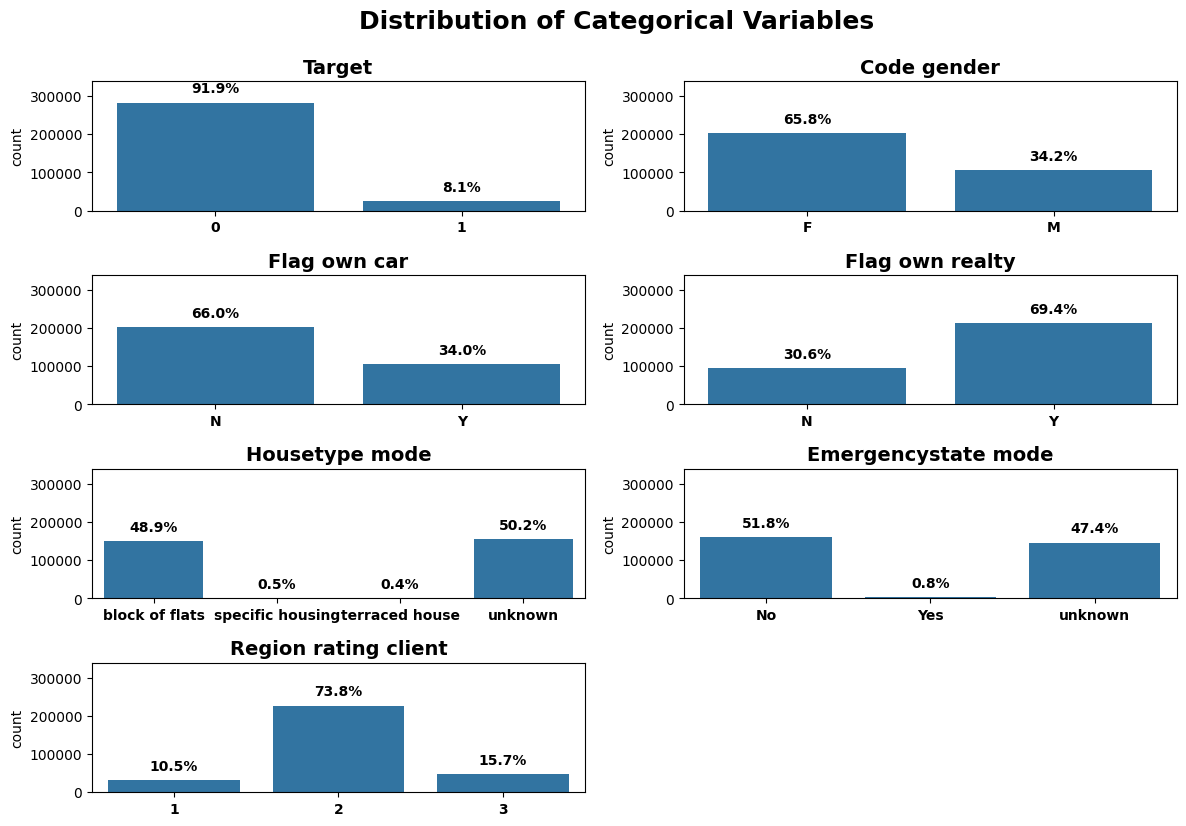

In [9]:
cols = ['TARGET', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 
        'HOUSETYPE_MODE', 'EMERGENCYSTATE_MODE', 'REGION_RATING_CLIENT'] 
plot_distribution_of_cat_variables(application_train.fillna('unknown'), 
                                   cols, [4, 2], 1.1, [14, 9], 0.9)

Most people did not have payment difficulties. Majority are female (66%), do not own a car (66%), own real estate (69%) and live in a block of flats (49%).

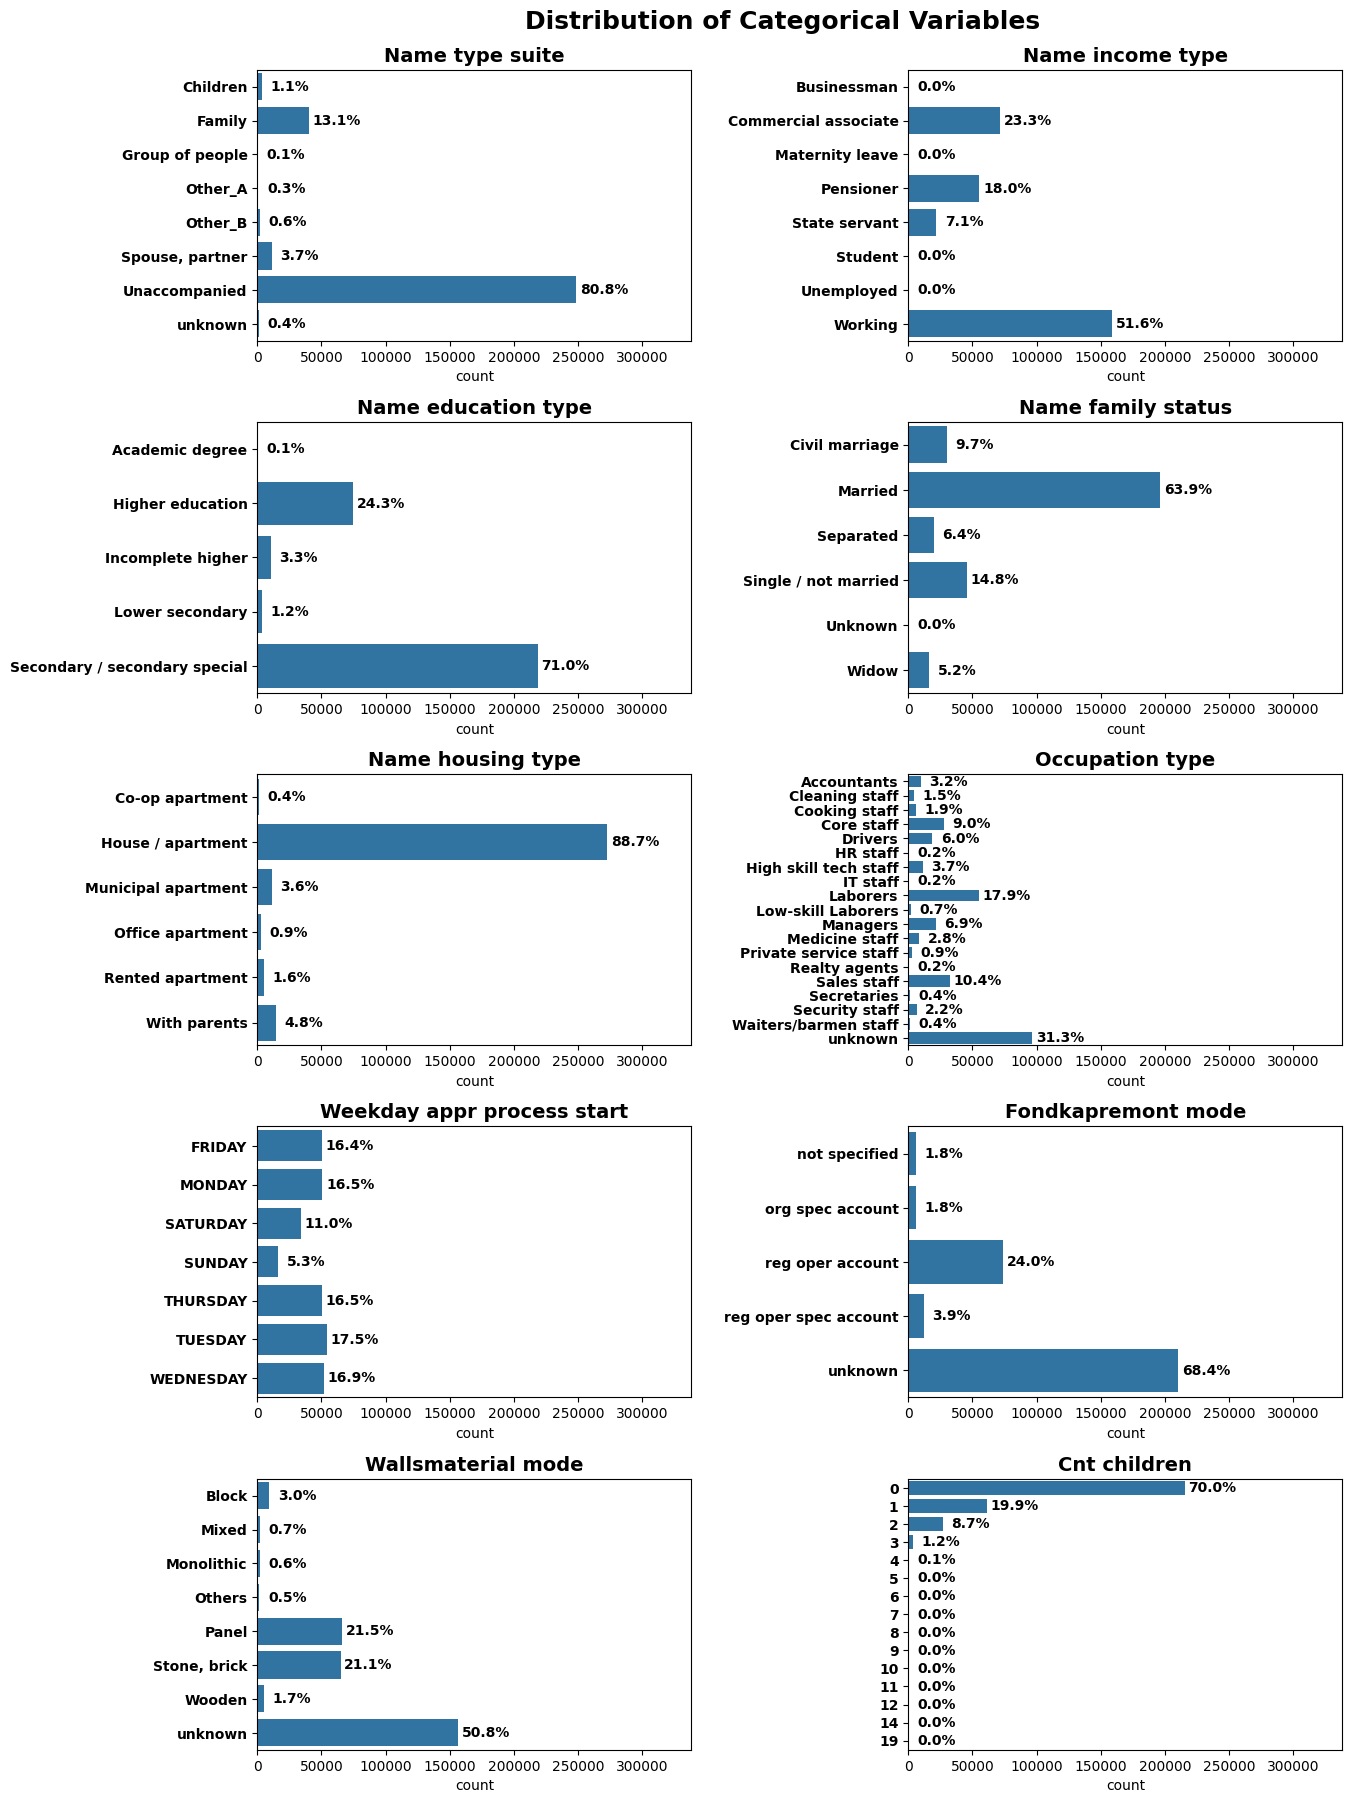

In [10]:
cols = ['NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 
        'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE', 
        'WEEKDAY_APPR_PROCESS_START', 'FONDKAPREMONT_MODE', 
        'WALLSMATERIAL_MODE', 'CNT_CHILDREN']
plot_distribution_of_cat_variables(application_train.fillna('unknown'), cols, [5, 2], 1.1, [14, 20], 0.95,
                                   orientation='h', space=[0.5, 0.3])

The majority of applicants have a job (52%), secondary education (71%), are married (64%), live in a house/apartment (89%), and have 0 (70%), 1 (20%), or 2 (9%) children.

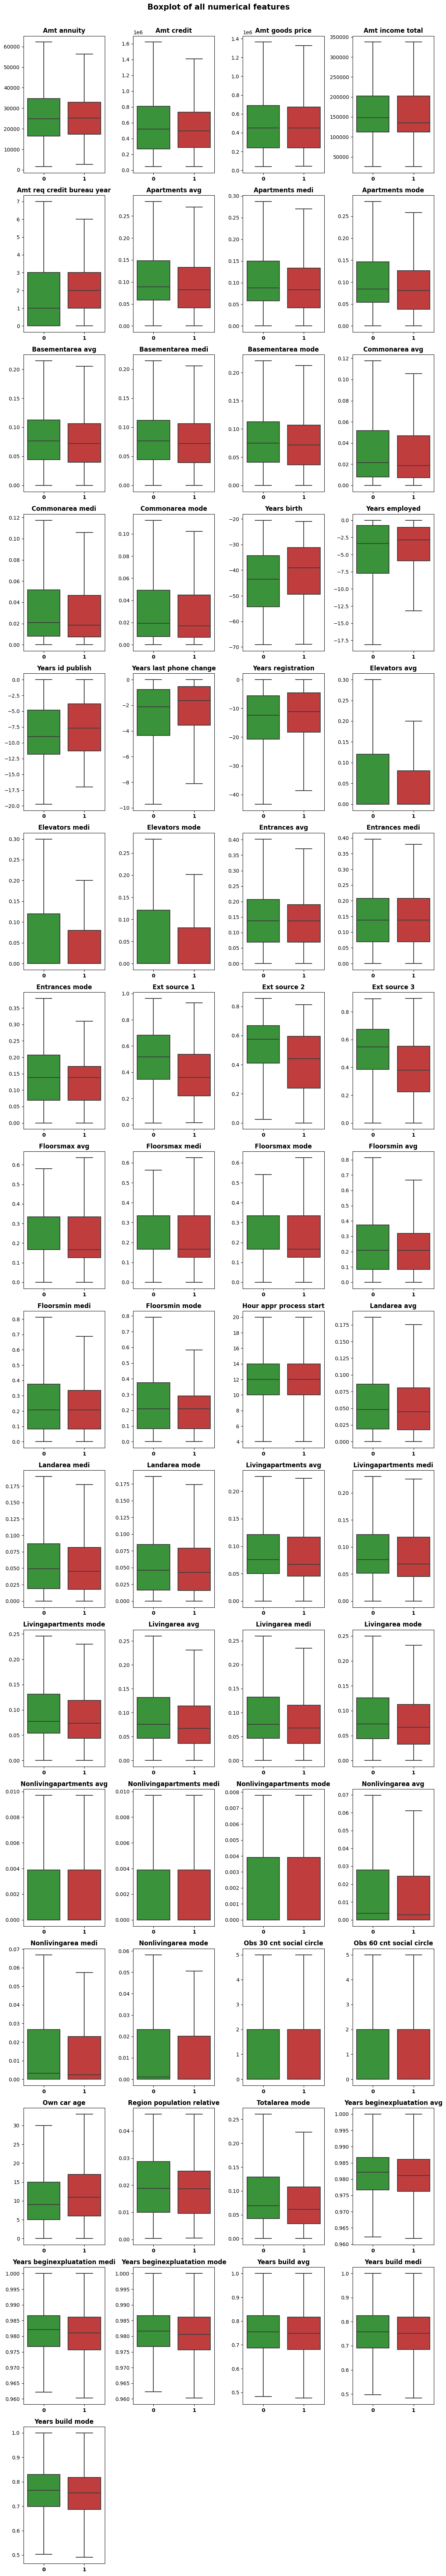

In [11]:
palette = {0: sns.color_palette('tab10')[2], 1: sns.color_palette('tab10')[3]}
make_multiple_boxplots(application_train, 
             ['AMT_ANNUITY', 'AMT_CREDIT', 'AMT_GOODS_PRICE', 'AMT_INCOME_TOTAL', 
              'AMT_REQ_CREDIT_BUREAU_YEAR', 'APARTMENTS_AVG', 'APARTMENTS_MEDI', 
              'APARTMENTS_MODE', 'BASEMENTAREA_AVG', 'BASEMENTAREA_MEDI', 'BASEMENTAREA_MODE', 
              'COMMONAREA_AVG', 'COMMONAREA_MEDI', 'COMMONAREA_MODE', 'YEARS_BIRTH', 
              'YEARS_EMPLOYED', 'YEARS_ID_PUBLISH', 'YEARS_LAST_PHONE_CHANGE', 
              'YEARS_REGISTRATION', 'ELEVATORS_AVG', 'ELEVATORS_MEDI', 'ELEVATORS_MODE', 
              'ENTRANCES_AVG', 'ENTRANCES_MEDI', 'ENTRANCES_MODE', 'EXT_SOURCE_1', 
              'EXT_SOURCE_2', 'EXT_SOURCE_3', 'FLOORSMAX_AVG', 'FLOORSMAX_MEDI', 
              'FLOORSMAX_MODE', 'FLOORSMIN_AVG', 'FLOORSMIN_MEDI', 'FLOORSMIN_MODE', 
              'HOUR_APPR_PROCESS_START', 'LANDAREA_AVG', 'LANDAREA_MEDI', 'LANDAREA_MODE', 
              'LIVINGAPARTMENTS_AVG', 'LIVINGAPARTMENTS_MEDI', 'LIVINGAPARTMENTS_MODE', 
              'LIVINGAREA_AVG', 'LIVINGAREA_MEDI', 'LIVINGAREA_MODE', 'NONLIVINGAPARTMENTS_AVG', 
              'NONLIVINGAPARTMENTS_MEDI', 'NONLIVINGAPARTMENTS_MODE', 'NONLIVINGAREA_AVG', 
              'NONLIVINGAREA_MEDI', 'NONLIVINGAREA_MODE', 'OBS_30_CNT_SOCIAL_CIRCLE', 
              'OBS_60_CNT_SOCIAL_CIRCLE', 'OWN_CAR_AGE', 'REGION_POPULATION_RELATIVE', 
              'TOTALAREA_MODE', 'YEARS_BEGINEXPLUATATION_AVG', 'YEARS_BEGINEXPLUATATION_MEDI', 
              'YEARS_BEGINEXPLUATATION_MODE', 'YEARS_BUILD_AVG', 'YEARS_BUILD_MEDI', 'YEARS_BUILD_MODE'], 
             'TARGET', [12, 70], 4, palette)

The boxplot chart reveals notable differences among groups based on their payment difficulties, particularly in the following features:

Payment difficulties are more prevalent among younger individuals (with a median age of about 39 as opposed to 44), individuals who have been employed for longer periods, and those with poorer living conditions (as indicated by the AVG, MEDI, MODE of Apartments, Living Apartments, and Living Area). Furthermore, these individuals tend to have older cars (with a median age of 11 years as opposed to 9) and change phones more frequently (typically every 1.6 years, compared to over two years for other groups).

These factors could play a significant role in the evaluation of loan applications.

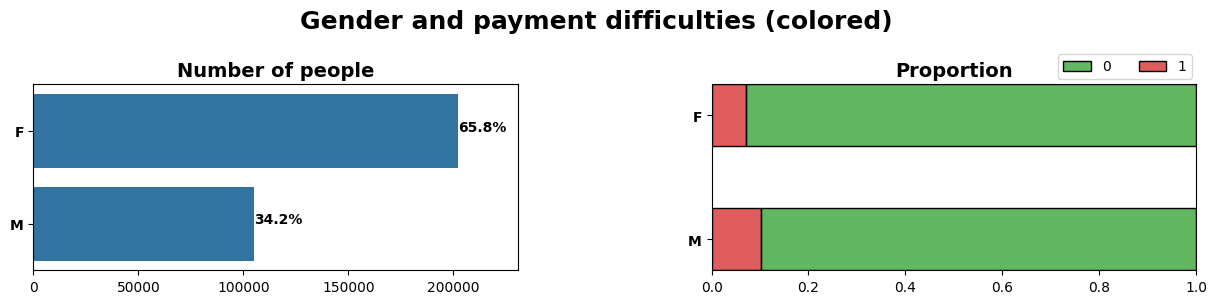

In [12]:
draw_double_chart(application_train.fillna('Unknown'), 'CODE_GENDER', 
                  [15, 3], palette, 'TARGET', 
                   'Gender and payment difficulties (colored)', 
                   top_value=0.73, bbox_to_anchor_value=(0.7, 1.2))

Male applicants had a little bit more payment difficulties than females.

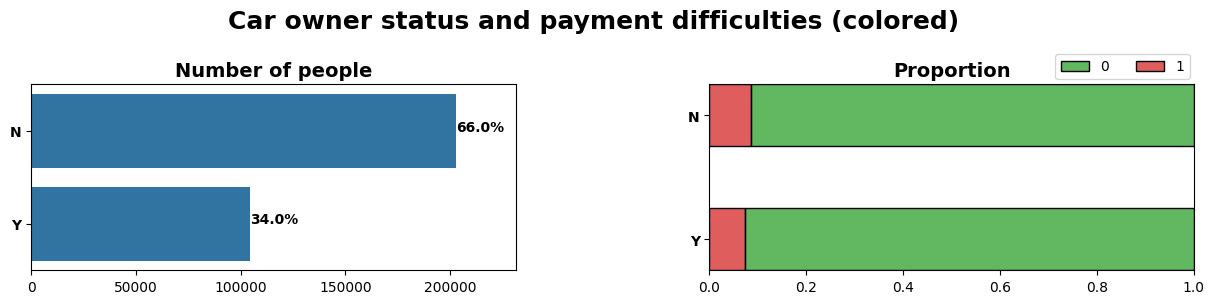

In [13]:
draw_double_chart(application_train.fillna('Unknown'), 'FLAG_OWN_CAR', 
                  [15, 3], palette, 'TARGET', 
                   'Car owner status and payment difficulties (colored)', 
                   top_value=0.73, bbox_to_anchor_value=(0.7, 1.2))

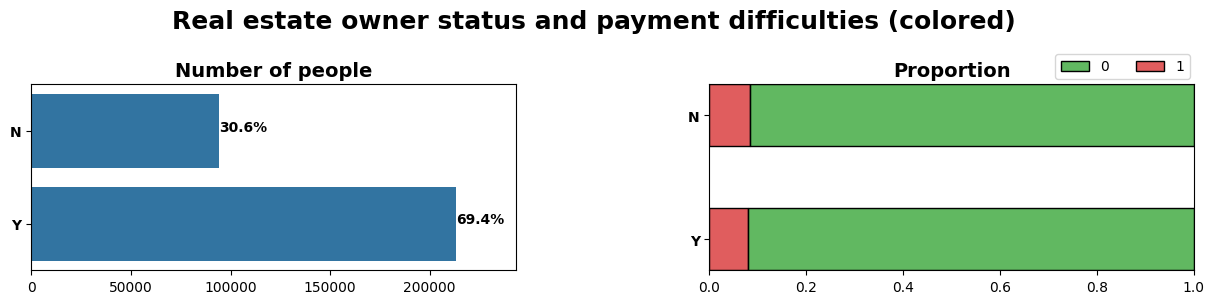

In [14]:
draw_double_chart(application_train.fillna('Unknown'), 'FLAG_OWN_REALTY', 
                  [15, 3], palette, 'TARGET', 
                   'Real estate owner status and payment difficulties (colored)', 
                   top_value=0.73, bbox_to_anchor_value=(0.7, 1.2))

People owning car or real estate have stlightly less payment difficulties.

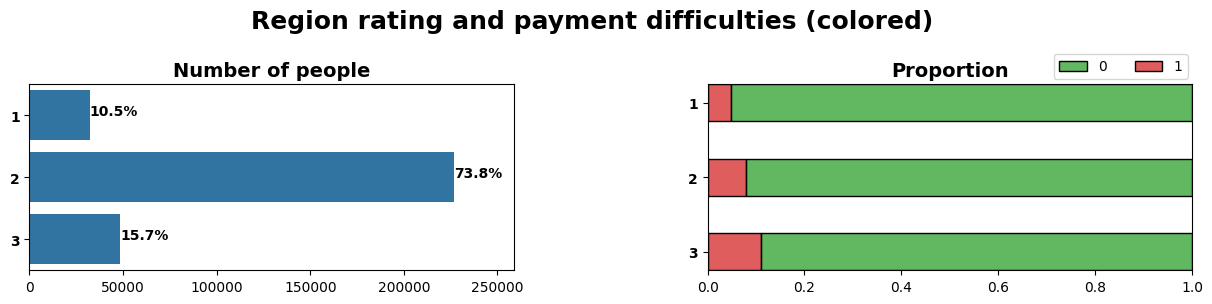

In [15]:
t = application_train.copy()
t['REGION_RATING_CLIENT'] = t['REGION_RATING_CLIENT'].astype(str)
draw_double_chart(t.fillna('Unknown'), 'REGION_RATING_CLIENT', 
                  [15, 3], palette, 'TARGET', 
                   'Region rating and payment difficulties (colored)', 
                   top_value=0.73, bbox_to_anchor_value=(0.7, 1.2))

Individuals from region rated 1 experienced fewer payment issues compared to those from region 3.

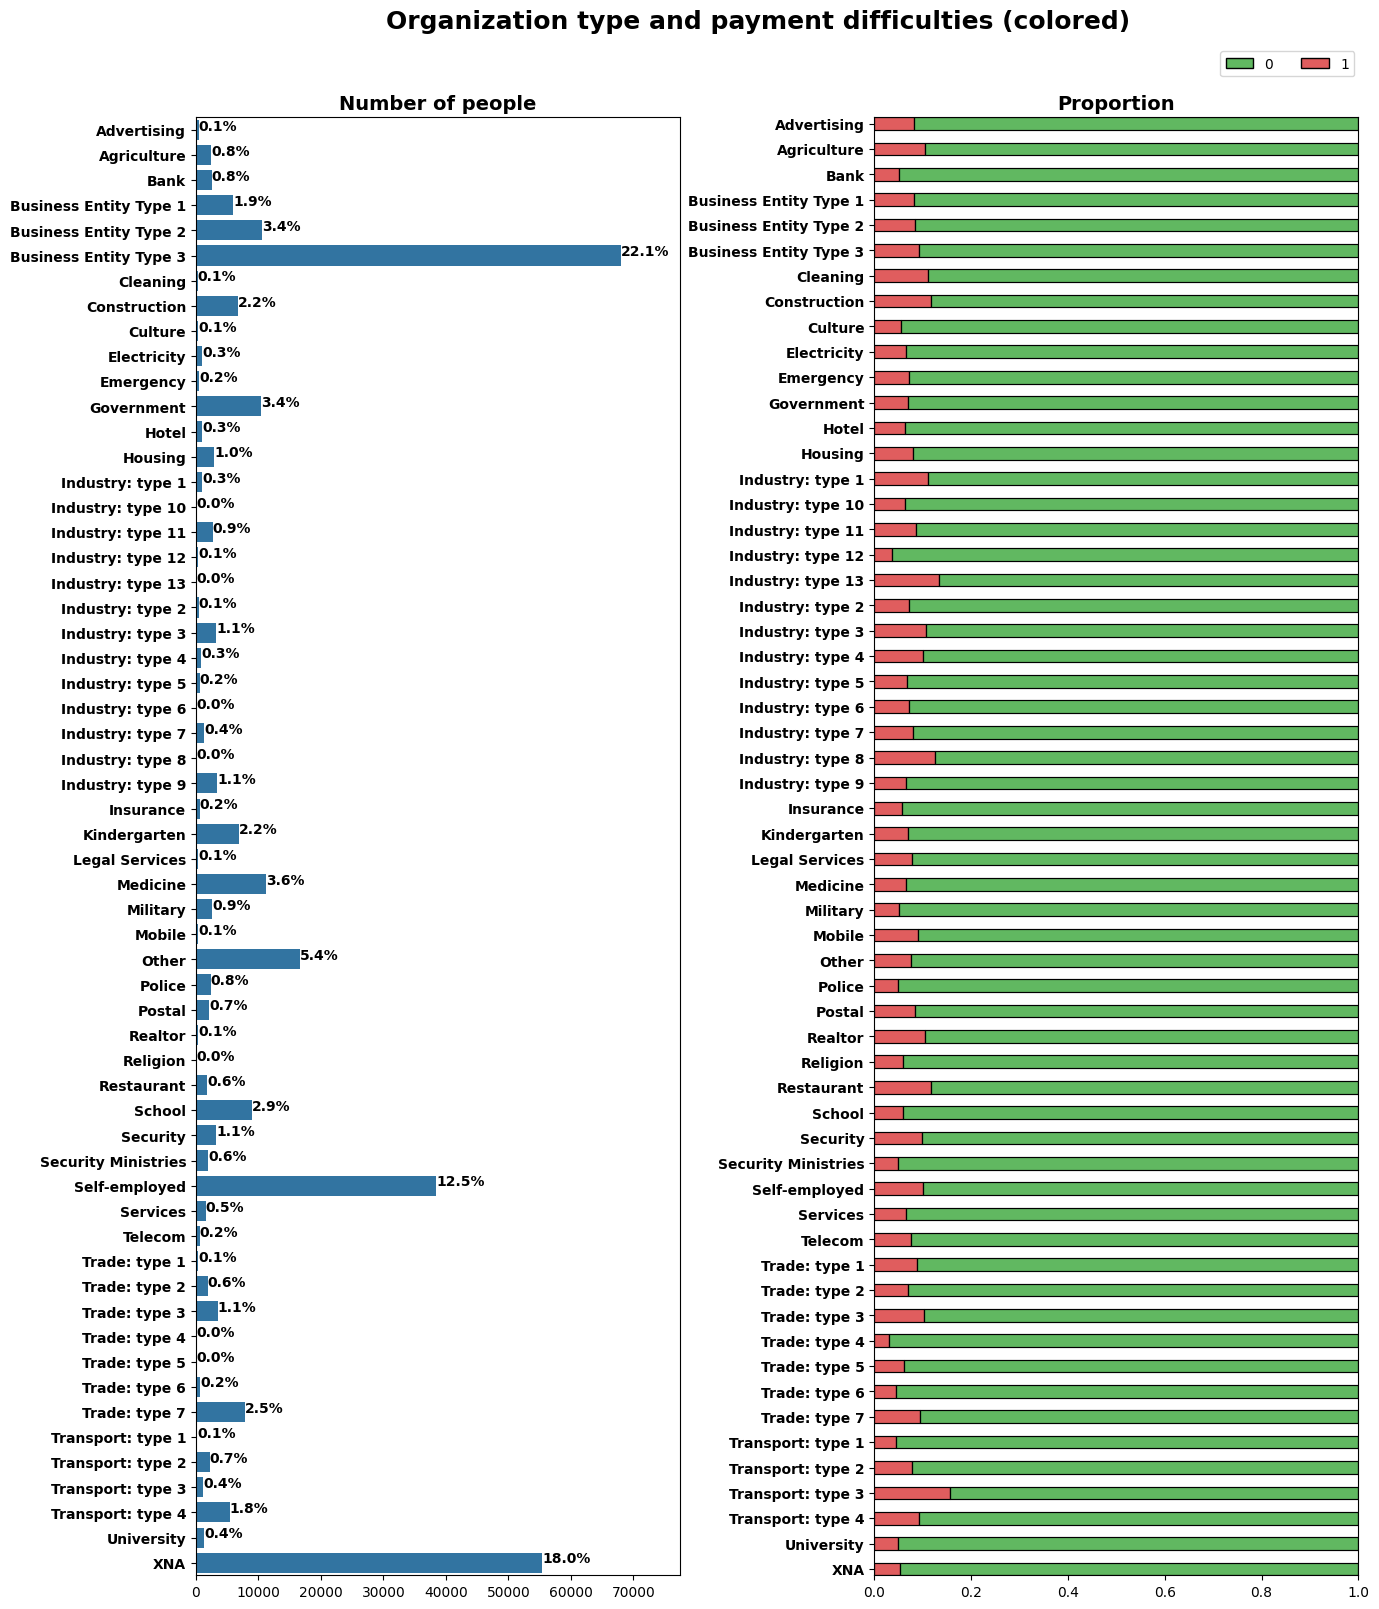

In [16]:
palette = {0: sns.color_palette('tab10')[2], 
           1: sns.color_palette('tab10')[3]}
draw_double_chart(application_train.fillna('unknown'), 'ORGANIZATION_TYPE', 
                  [15, 18], palette, 'TARGET', 
                   'Organization type and payment difficulties (colored)', 
                   top_value=0.92, bbox_to_anchor_value=(0.7, 1.05))

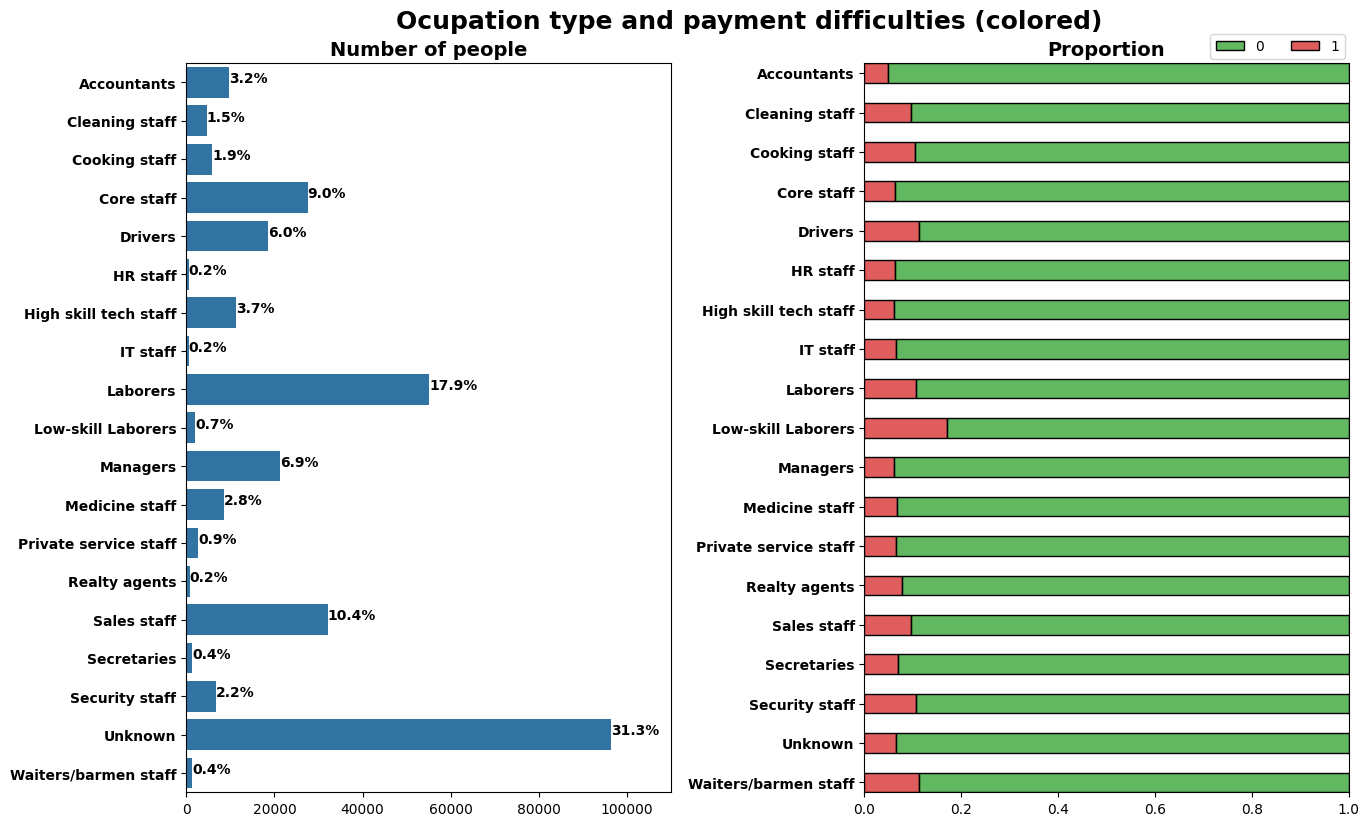

In [17]:
draw_double_chart(application_train.fillna('Unknown'), 'OCCUPATION_TYPE', 
                  [15, 9], palette, 'TARGET', 
                   'Ocupation type and payment difficulties (colored)', 
                   top_value=0.92, bbox_to_anchor_value=(0.7, 1.05))

Payment difficulties looks related with salary - low skill laborers, cleaning, cooking staff, drivers have more payment difficulties than IT staff, high skill tech staff or managers.

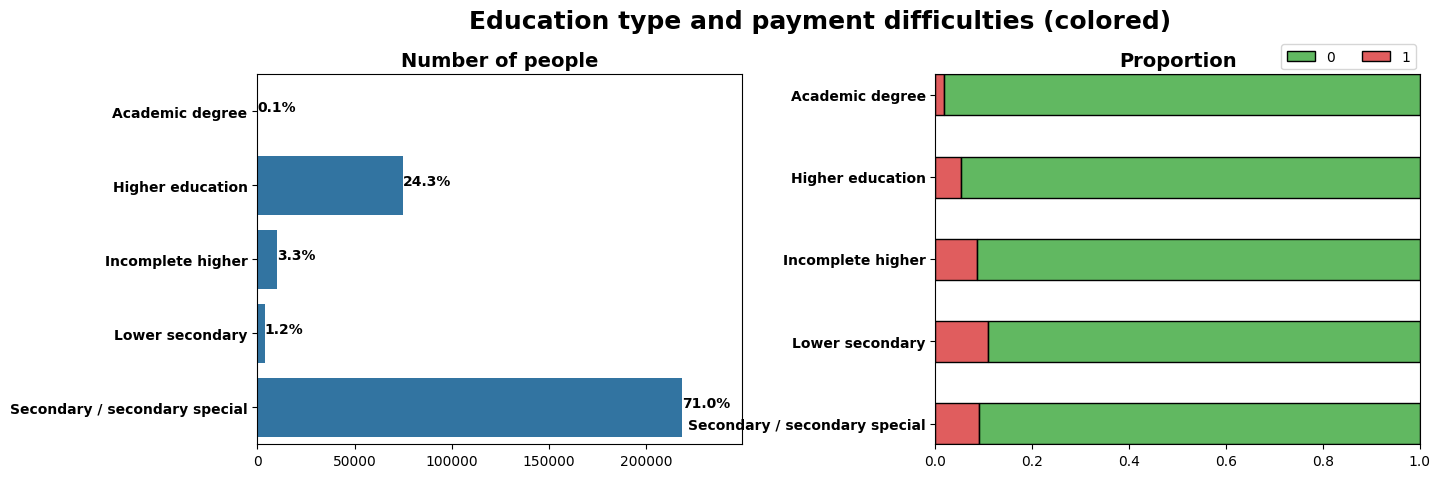

In [7]:
draw_double_chart(application_train.fillna('Unknown'), 'NAME_EDUCATION_TYPE', 
                  [15, 5], palette, 'TARGET', 
                   'Education type and payment difficulties (colored)', 
                   top_value=0.85, bbox_to_anchor_value=(0.7, 1.1))

Less educated individuals tend to have less payment difficulties.

#### Feature importance
##### Numeric features

To determine whether the features have predictive value for loan status, a **z-test** was conducted. <br>
The purpose of the z-test was to assess whether there is a statistically significant difference in the mean values of the features between 2 groups (the ones that had payment difficulties and the ones without it). By comparing the mean values, we can evaluate if the features exhibit distinct patterns that contribute to predicting the payment difficulties.

<b>Parameter of Interest</b>: $\mu$, population mean <br>
<b>Null hypothesis</b>: Two group means are equal $\mu_1 = \mu_2$<br>
<b>Alternative hypothesis</b>: Two group means are not equal $\mu_1 \neq \mu_2$ (two-sided)  <br>
<b>Significance level</b>: 0.05

In [12]:
features = ['YEARS_EMPLOYED', 'AMT_CREDIT', 'YEARS_ID_PUBLISH', 'AMT_INCOME_TOTAL']
for feature in features:
  group_a = application_train[application_train['TARGET'] == 0][feature]
  group_b = application_train[application_train['TARGET'] == 1][feature]
  _, p_val = ztest(group_a, group_b)
  print('Feature:', feature)
  if float(p_val)<0.05:
    print('p-value is', p_val, 
          '< 0.05. This feature could be helpful to predict the payment difficulties.')
  else:
    print('p-value is', p_val, 
          '> 0.05. This feature would not be helpful to predict the payment difficulties.')
  print()

Feature: YEARS_EMPLOYED
p-value is 2.5887053850924327e-137 < 0.05. This feature could be helpful to predict the payment difficulties.

Feature: AMT_CREDIT
p-value is 1.0563203842438503e-63 < 0.05. This feature could be helpful to predict the payment difficulties.

Feature: YEARS_ID_PUBLISH
p-value is 1.4858957906173308e-179 < 0.05. This feature could be helpful to predict the payment difficulties.

Feature: AMT_INCOME_TOTAL
p-value is 0.027249380335415976 < 0.05. This feature could be helpful to predict the payment difficulties.



##### Categorical features

Which of the categorical features are could be used in the model?

Let's perform χ2 test to see if there is a relationship between having payment difficulties and categorical features. <br>
χ2 test of Independence is used to decide whether there is a relationship exists between two variables of a population.

<b>Parameter of Interest</b>: The relationship between payment difficulties feature and another categorical feature. <br>
<b>Null hypothesis</b>: There is no significant association between these two features.<br>
<b>Alternative hypothesis</b>: There is a significant association between these two features. <br>
<b>Significance level</b>: 0.05


In [13]:
features = ['FLAG_DOCUMENT_10', 'NAME_EDUCATION_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR',
            'FLAG_DOCUMENT_21', 'ORGANIZATION_TYPE', 'OCCUPATION_TYPE', 'NAME_EDUCATION_TYPE']
for feature in features:
  t = application_train.copy()
  cont_table = pd.crosstab(t[feature], t['TARGET'])
  _, p_val, _, _ = chi2_contingency(cont_table)
  print('Feature:', feature)
  if float(p_val)<0.05:
    print('p-value is', p_val, '< 0.05. This feature could be helpful to predict the payment difficulties.')
  else:
    print('p-value is', p_val, '> 0.05. This feature would not be helpful to predict the payment difficulties.')
  print()

Feature: FLAG_DOCUMENT_10
p-value is 0.9280205484499577 > 0.05. This feature would not be helpful to predict the payment difficulties.

Feature: NAME_EDUCATION_TYPE
p-value is 2.4627681872810625e-219 < 0.05. This feature could be helpful to predict the payment difficulties.

Feature: CODE_GENDER
p-value is 4.394091339983112e-202 < 0.05. This feature could be helpful to predict the payment difficulties.

Feature: FLAG_OWN_CAR
p-value is 9.410574445435375e-34 < 0.05. This feature could be helpful to predict the payment difficulties.

Feature: FLAG_DOCUMENT_21
p-value is 0.06070477781747027 > 0.05. This feature would not be helpful to predict the payment difficulties.

Feature: ORGANIZATION_TYPE
p-value is 5.234820758918666e-299 < 0.05. This feature could be helpful to predict the payment difficulties.

Feature: OCCUPATION_TYPE
p-value is 3.407254056720513e-288 < 0.05. This feature could be helpful to predict the payment difficulties.

Feature: NAME_EDUCATION_TYPE
p-value is 2.46276818728

### Previous application

In [54]:
df_previous_application = pd.read_csv(f'data/previous_application.csv')
print(df_previous_application.shape)
df_previous_application.head()

(1670214, 37)


,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,FLAG_LAST_APPL_PER_CONTRACT,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,NAME_CASH_LOAN_PURPOSE,NAME_CONTRACT_STATUS,DAYS_DECISION,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_TYPE_SUITE,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,CHANNEL_TYPE,SELLERPLACE_AREA,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,Y,1,0.0,0.182832,0.867336,XAP,Approved,-73,Cash through the bank,XAP,NaN,Repeater,Mobile,POS,XNA,Country-wide,35,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,Y,1,NaN,NaN,NaN,XNA,Approved,-164,XNA,XAP,Unaccompanied,Repeater,XNA,Cash,x-sell,Contact center,-1,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,NaN,112500.0,TUESDAY,11,Y,1,NaN,NaN,NaN,XNA,Approved,-301,Cash through the bank,XAP,"Spouse, partner",Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0
3,2819243,176158,Cash loans,47041.335,450000.0,470790.0,NaN,450000.0,MONDAY,7,Y,1,NaN,NaN,NaN,XNA,Approved,-512,Cash through the bank,XAP,NaN,Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0
4,1784265,202054,Cash loans,31924.395,337500.0,404055.0,NaN,337500.0,THURSDAY,9,Y,1,NaN,NaN,NaN,Repairs,Refused,-781,Cash through the bank,HC,NaN,Repeater,XNA,Cash,walk-in,Credit and cash offices,-1,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
df_previous_application['DAYS_FIRST_DRAWING'].value_counts().to_frame('count')

,count
365243.0,934444
-228.0,123
-224.0,121
-212.0,121
-223.0,119
...,...
-1854.0,1
-1990.0,1
-1995.0,1
-1687.0,1


In [55]:
df_previous_application['DAYS_FIRST_DRAWING'].value_counts().to_frame('count')
cols = ['DAYS_DECISION', 'DAYS_FIRST_DRAWING', 'DAYS_FIRST_DUE', 
        'DAYS_LAST_DUE', 'DAYS_LAST_DUE_1ST_VERSION',
       'DAYS_TERMINATION']
df_previous_application[cols] = df_previous_application[cols].replace(365243, np.nan)

365243 days (1000 years) in certain date columns are considered errors and replaced with NaN.

In [53]:
for col in cols:
    df_previous_application[col] = (df_previous_application[col] / 365).round(2)
df_previous_application.columns = [s.replace('DAYS', 'YEARS') for s in list(df_previous_application.columns)]

Days converted to years.

In [18]:
(df_previous_application.isnull().sum()/len(df_previous_application)*100)\
    .sort_values(ascending=False)\
    .round(1).to_frame(name='missing values %').head(15)

,missing values %
RATE_INTEREST_PRIVILEGED,99.6
RATE_INTEREST_PRIMARY,99.6
YEARS_FIRST_DRAWING,96.2
YEARS_TERMINATION,53.8
AMT_DOWN_PAYMENT,53.6
RATE_DOWN_PAYMENT,53.6
YEARS_LAST_DUE,52.9
NAME_TYPE_SUITE,49.1
YEARS_LAST_DUE_1ST_VERSION,45.9
YEARS_FIRST_DUE,42.7


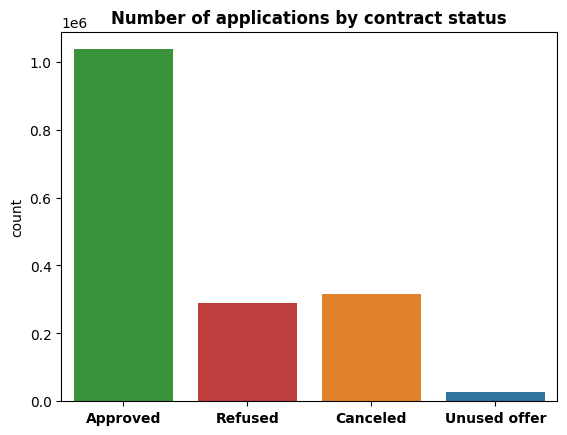

In [19]:
palette = {'Approved': sns.color_palette('tab10')[2], 
           'Canceled': sns.color_palette('tab10')[1],
            'Unused offer': sns.color_palette('tab10')[0], 
            'Refused': sns.color_palette('tab10')[3]}
sns.countplot(x=df_previous_application['NAME_CONTRACT_STATUS'], palette=palette)\
    .set_title('Number of applications by contract status', weight='bold')
plt.gca().set_xticklabels(plt.gca().get_xticklabels(), weight='bold')
plt.xlabel('')
plt.show()

Looking at all applications, the majority of them were approved (60%). 
Some applications were also cancelled by the applicant. 

In [20]:
t1 = df_previous_application['SK_ID_CURR'].value_counts()\
    .describe().round(1).to_frame(name='all applications')
t2 = df_previous_application[df_previous_application['NAME_CONTRACT_STATUS']=='Approved']['SK_ID_CURR']\
    .value_counts().describe().round(1).to_frame(name='approved applications')
t1.join(t2)

,all applications,approved applications
count,338857.0,337698.0
mean,4.9,3.1
std,4.2,2.1
min,1.0,1.0
25%,2.0,1.0
50%,4.0,3.0
75%,7.0,4.0
max,77.0,27.0


The dataset shows a wide range of application counts per applicant. The maximum number of applications made by a single entity is 77, while the average number is around 5. However, when focusing on approved applications only, the maximum number decreases to 27, and the average number reduces to approximately 3.

In [21]:
df_previous_application.head()

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,FLAG_LAST_APPL_PER_CONTRACT,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,NAME_CASH_LOAN_PURPOSE,NAME_CONTRACT_STATUS,YEARS_DECISION,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_TYPE_SUITE,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,CHANNEL_TYPE,SELLERPLACE_AREA,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,YEARS_FIRST_DRAWING,YEARS_FIRST_DUE,YEARS_LAST_DUE_1ST_VERSION,YEARS_LAST_DUE,YEARS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430,17145.0,17145.0,0.0,17145.0,SATURDAY,15,Y,1,0.0,0.182832,0.867336,XAP,Approved,-0.20,Cash through the bank,XAP,NaN,Repeater,Mobile,POS,XNA,Country-wide,35,Connectivity,12.0,middle,POS mobile with interest,NaN,-0.12,0.82,-0.12,-0.10,0.0
1,2802425,108129,Cash loans,25188.615,607500.0,679671.0,NaN,607500.0,THURSDAY,11,Y,1,NaN,NaN,NaN,XNA,Approved,-0.45,XNA,XAP,Unaccompanied,Repeater,XNA,Cash,x-sell,Contact center,-1,XNA,36.0,low_action,Cash X-Sell: low,NaN,-0.37,2.51,NaN,NaN,1.0
2,2523466,122040,Cash loans,15060.735,112500.0,136444.5,NaN,112500.0,TUESDAY,11,Y,1,NaN,NaN,NaN,XNA,Approved,-0.82,Cash through the bank,XAP,"Spouse, partner",Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.0,high,Cash X-Sell: high,NaN,-0.74,0.16,NaN,NaN,1.0
3,2819243,176158,Cash loans,47041.335,450000.0,470790.0,NaN,450000.0,MONDAY,7,Y,1,NaN,NaN,NaN,XNA,Approved,-1.40,Cash through the bank,XAP,NaN,Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.0,middle,Cash X-Sell: middle,NaN,-1.32,-0.42,-0.50,-0.48,1.0
4,1784265,202054,Cash loans,31924.395,337500.0,404055.0,NaN,337500.0,THURSDAY,9,Y,1,NaN,NaN,NaN,Repairs,Refused,-2.14,Cash through the bank,HC,NaN,Repeater,XNA,Cash,walk-in,Credit and cash offices,-1,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN


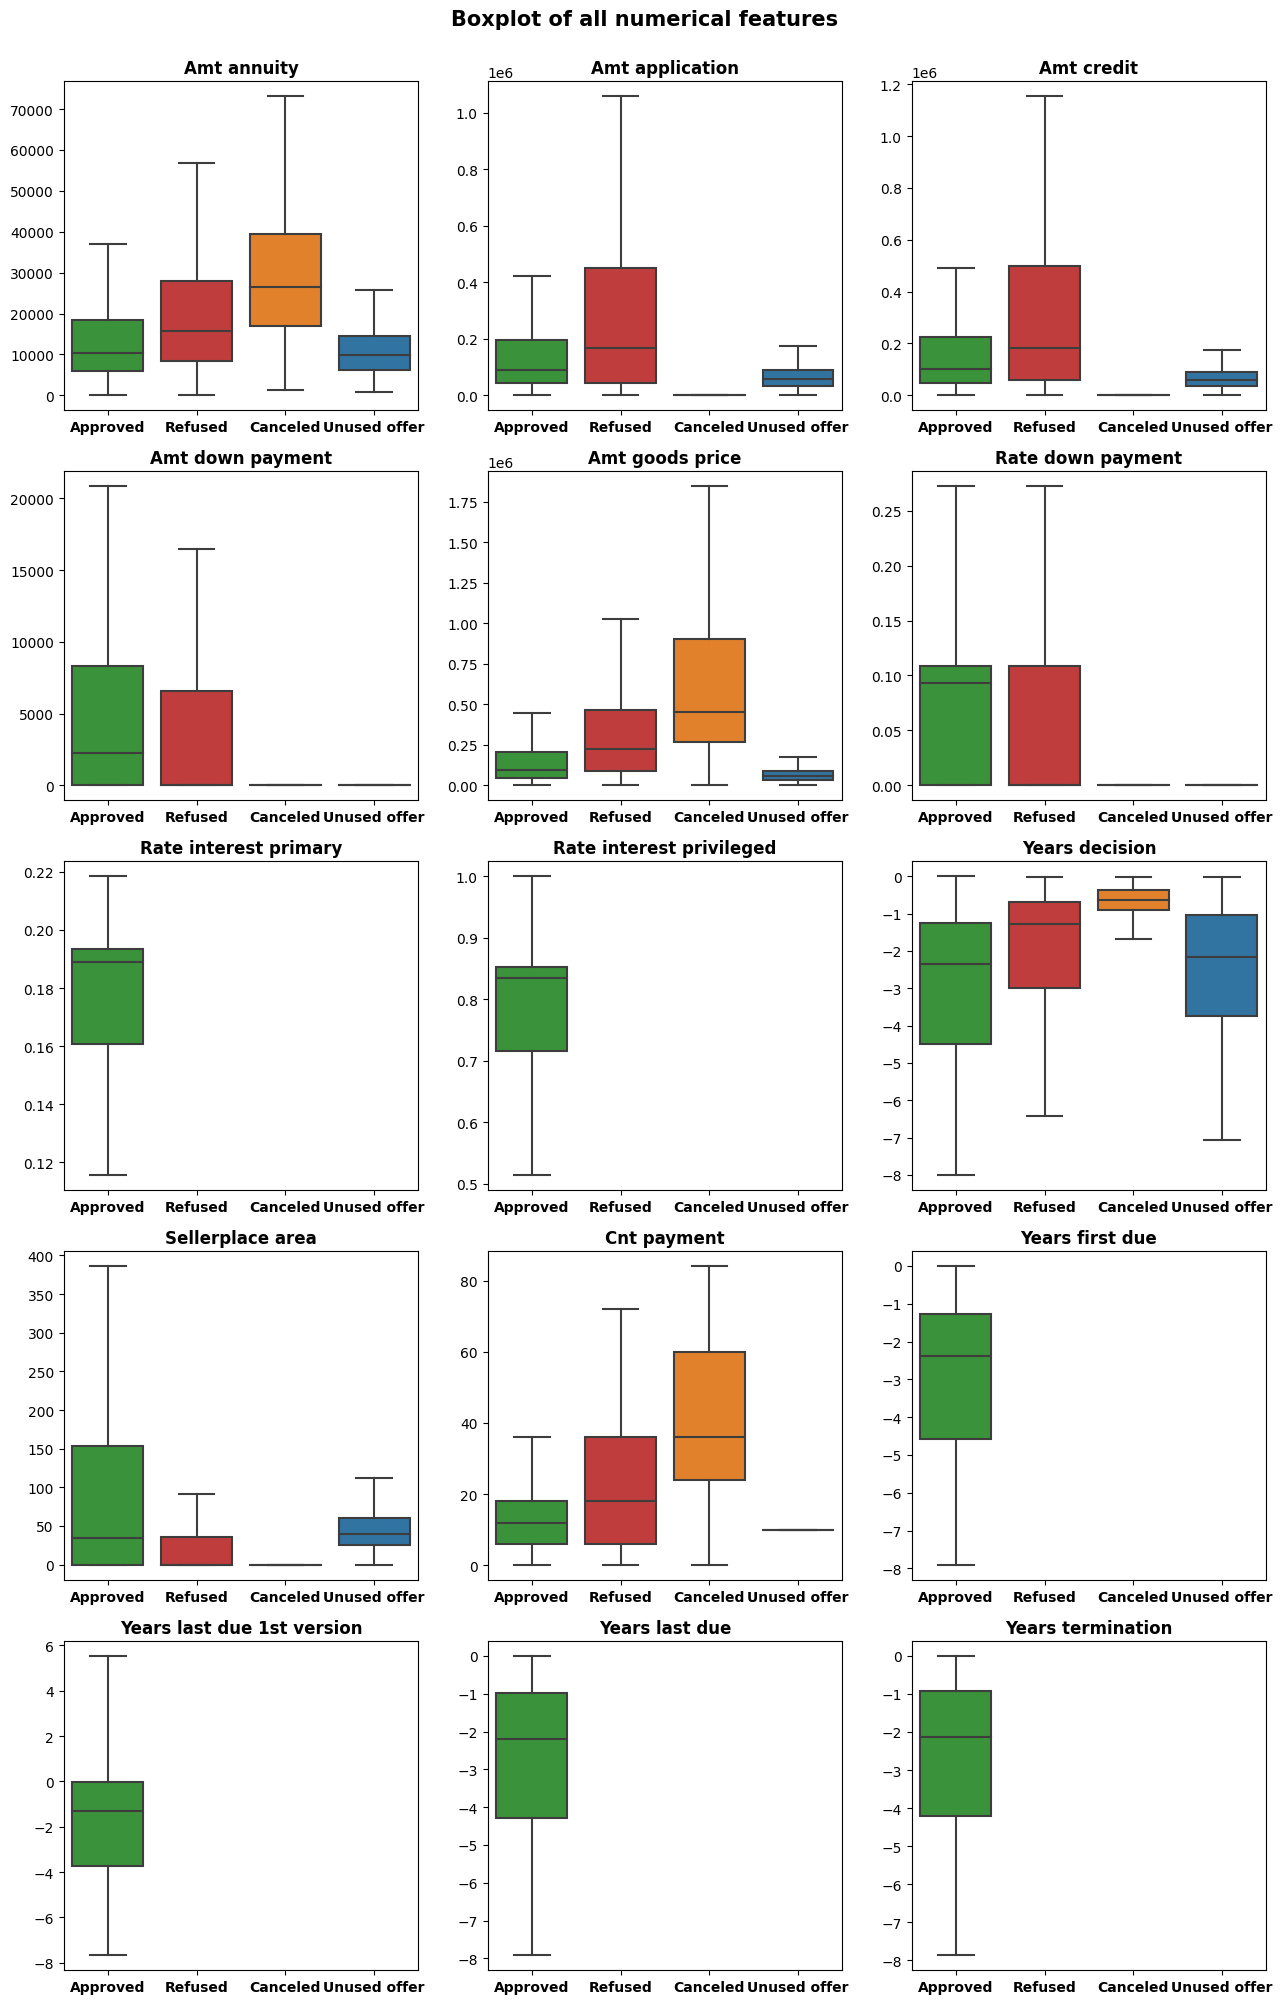

In [22]:
numeric_columns = ['AMT_ANNUITY', 'AMT_APPLICATION', 'AMT_CREDIT', 
                   'AMT_DOWN_PAYMENT', 'AMT_GOODS_PRICE',
                   'RATE_DOWN_PAYMENT', 'RATE_INTEREST_PRIMARY', 
                   'RATE_INTEREST_PRIVILEGED',
                   'YEARS_DECISION', 'SELLERPLACE_AREA', 'CNT_PAYMENT',
                   'YEARS_FIRST_DUE', 'YEARS_LAST_DUE_1ST_VERSION', 
                   'YEARS_LAST_DUE', 'YEARS_TERMINATION']
make_multiple_boxplots(df_previous_application, numeric_columns, 
                       'NAME_CONTRACT_STATUS', [13, 20], 3, palette)

* Approved loans generally have lower annuity amounts compared to the loans that were cancelled or refused. In contrast, cancelled loans have the highest annuity amounts. The annuity amount represents the regular installment payment that borrowers need to pay towards the loan.
* The amount of credit requested by clients in the previous application is smaller for approved loans compared to refused loans.
* The approved loans have a significantly higher median downpayment amount compared to the refused loans. In the refused loans, the median downpayment amount is 0.
* Decision to refuse loan takes less time than to approve one (median of 1.3 vs 2.3 years).
* Primary customers receive interest rates ranging from 0.16 to 0.19, while privileged customers receive rates ranging from 0.07 to 0.09.
* Approved loans generally have a lower median value for the "cnt_payment" column, indicating a smaller number of payments or installments agreed upon, compared to the refused loans.

In [23]:
df_previous_application[df_previous_application['AMT_CREDIT']==0]\
    ['NAME_CONTRACT_STATUS'].value_counts()

Canceled        305566
Refused          29159
Approved          1551
Unused offer       492
Name: NAME_CONTRACT_STATUS, dtype: int64

Even some approved applications have approved credit amount of 0 in the data.

In [24]:
df_previous_application['NAME_CONTRACT_TYPE'].value_counts()

Cash loans         747553
Consumer loans     729151
Revolving loans    193164
XNA                   346
Name: NAME_CONTRACT_TYPE, dtype: int64

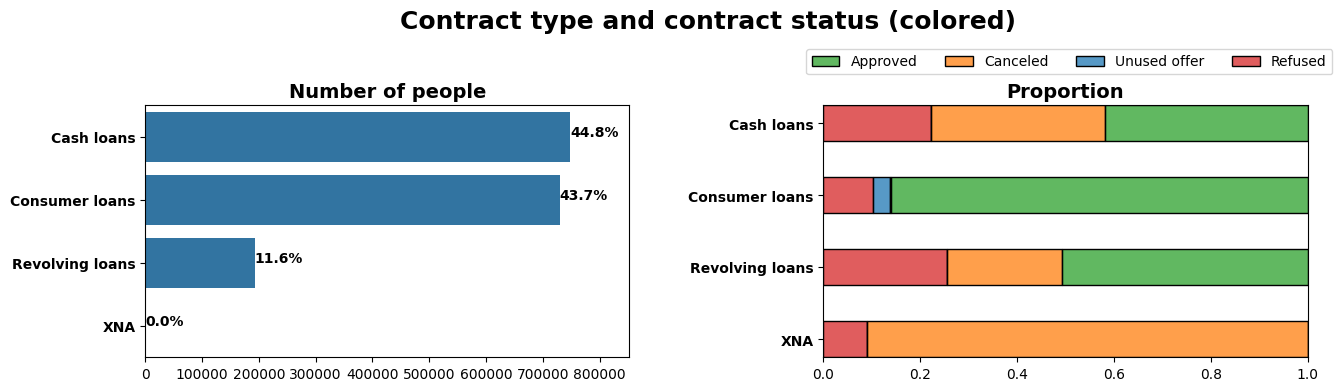

In [25]:
palette = {'Approved': sns.color_palette('tab10')[2], 
           'Canceled': sns.color_palette('tab10')[1],
           'Unused offer': sns.color_palette('tab10')[0], 
           'Refused': sns.color_palette('tab10')[3]}
draw_double_chart(df_previous_application, 'NAME_CONTRACT_TYPE', 
                  [15, 4], palette, 'NAME_CONTRACT_STATUS', 
                   'Contract type and contract status (colored)', 
                   top_value=0.74, bbox_to_anchor_value=(-0.05, 1.25))

More consumer type loans were approved than cash or revolving loans.

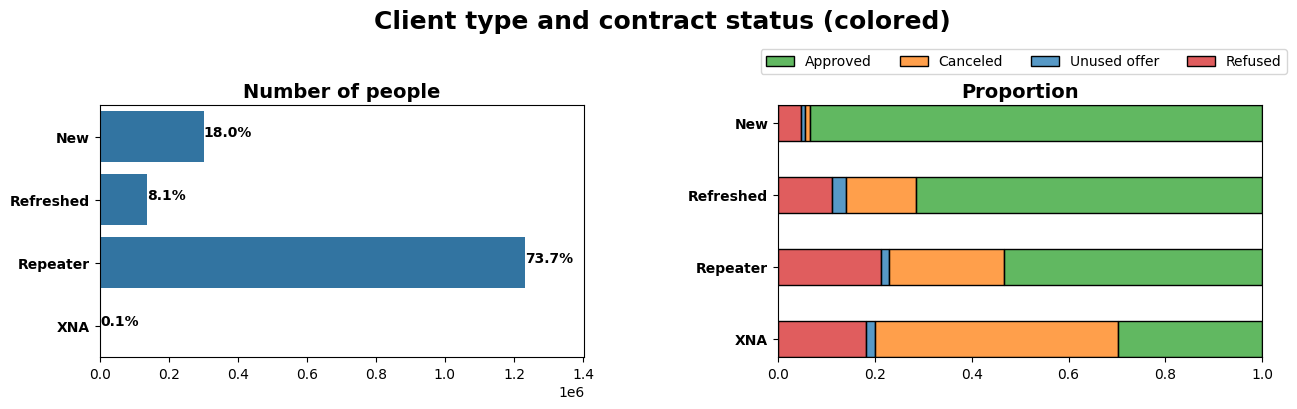

In [26]:
draw_double_chart(df_previous_application, 'NAME_CLIENT_TYPE', 
                  [15, 4], palette, 'NAME_CONTRACT_STATUS', 
                   'Client type and contract status (colored)',
                   top_value=0.74, bbox_to_anchor_value=(-0.05, 1.25))

New customers get the loan approved more often than refreshed or repeater customers.

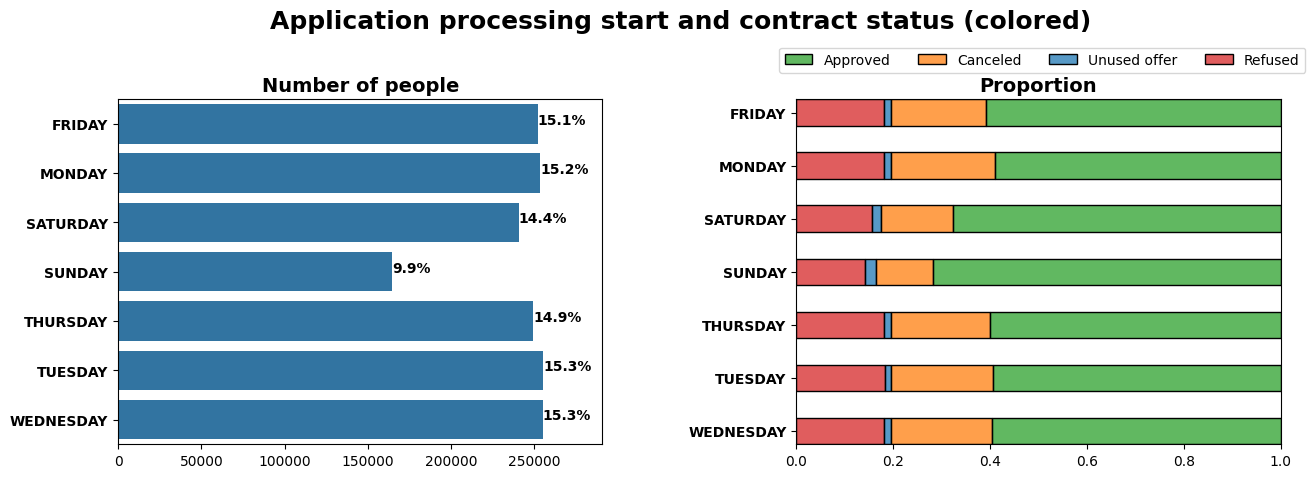

In [27]:
draw_double_chart(df_previous_application, 'WEEKDAY_APPR_PROCESS_START', 
                  [15, 5], palette, 'NAME_CONTRACT_STATUS', 
                   'Application processing start and contract status (colored)', 
                   top_value=0.8, bbox_to_anchor_value=(-0.05, 1.17))

Customers who apply for the loan on Saturdays and Sundays get application accepted more often.

### Bureau data

The "bureau" dataset contains information about a customer's credit history and their past interactions with other financial institutions or lenders.

In [28]:
df_bureau = pd.read_csv(f'data/bureau.csv')
print(df_bureau.shape)
df_bureau.head()

(1716428, 17)


,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


In [29]:
np.round(t.isnull().sum()/len(t)*100,2).sort_values(ascending=False).to_frame('missing values %')

,missing values %
COMMONAREA_MEDI,69.87
COMMONAREA_AVG,69.87
COMMONAREA_MODE,69.87
NONLIVINGAPARTMENTS_MODE,69.43
NONLIVINGAPARTMENTS_AVG,69.43
...,...
NAME_FAMILY_STATUS,0.00
NAME_EDUCATION_TYPE,0.00
NAME_INCOME_TYPE,0.00
AMT_ANNUITY,0.00


Taking the most recent information per applicant:

In [30]:
t = df_bureau.groupby('SK_ID_CURR').max('DAYS_CREDIT').reset_index()
print(t.shape)
t.describe().round(1).iloc[:, 2:]

(305811, 14)


,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
count,305811.0,305811.0,303226.0,268155.0,212971.0,305811.0,305809.0,297439.0,280503.0,305811.0,305811.0,118224.0
mean,-490.9,4.4,4508.6,-524.0,9012.3,0.0,991757.2,530039.6,21888.1,176.4,-139.3,38878.2
std,533.5,85.6,9422.7,529.7,343185.8,0.2,2317441.9,1357630.4,84545.4,13686.5,344.8,643544.4
min,-2922.0,0.0,-41875.0,-2887.0,0.0,0.0,0.0,-25959.6,-1747.0,0.0,-41890.0,0.0
25%,-623.0,0.0,126.0,-712.0,0.0,0.0,180000.0,0.0,0.0,0.0,-49.0,2250.0
50%,-305.0,0.0,912.0,-345.0,0.0,0.0,450000.0,152617.5,0.0,0.0,-18.0,13500.0
75%,-149.0,0.0,1692.0,-153.0,5749.1,0.0,1079100.0,505996.8,0.0,0.0,-9.0,29625.0
max,0.0,2792.0,31199.0,0.0,115987185.0,9.0,585000000.0,170100000.0,4705600.3,3756681.0,372.0,118453423.5


In [31]:
np.round(df_bureau['CREDIT_TYPE'].value_counts()/len(df_bureau)*100,2).reset_index(name = 'records %').head(4)

,index,records %
0,Consumer credit,72.92
1,Credit card,23.43
2,Car loan,1.61
3,Mortgage,1.07


The most common credit types are consumer credit and credit card.

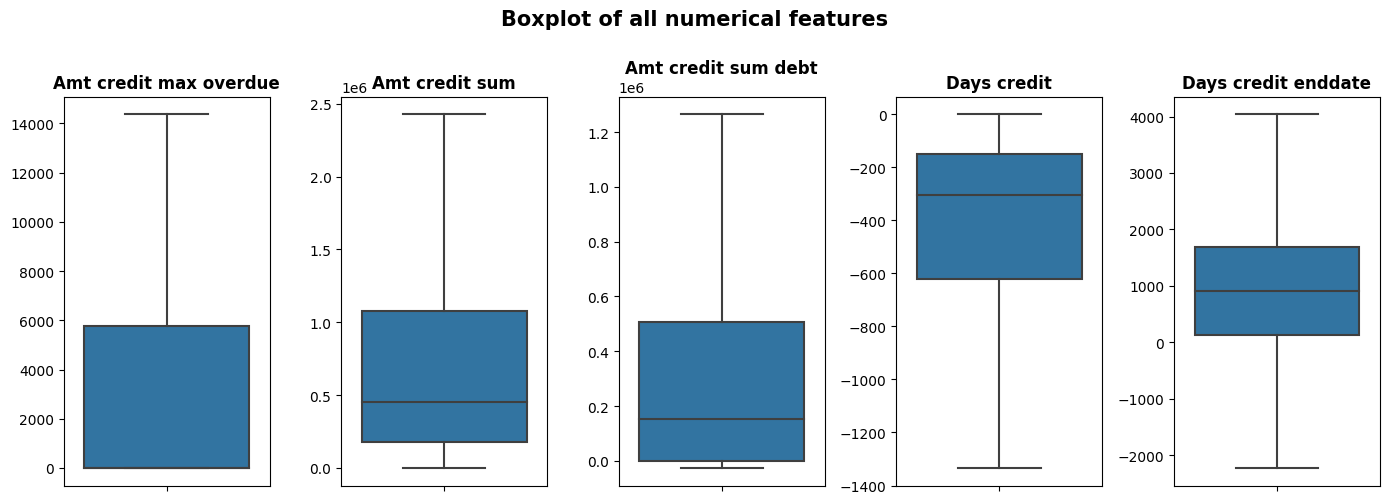

In [32]:
numeric_columns = ['AMT_CREDIT_MAX_OVERDUE', 'AMT_CREDIT_SUM', 'AMT_CREDIT_SUM_DEBT', 
                   'DAYS_CREDIT', 'DAYS_CREDIT_ENDDATE']
make_multiple_boxplots(t, numeric_columns, '', [14, 5], 5, '')

Bureau data with the most recent information per applicant:
* The duration between the client's previous Credit Bureau credit application and the current loan application is between 200 to 600 days, median is 300 days. (Days Credit)
* The remaining duration of the Credit Bureau credit at the time of application in Home Credit ranges from 0 to 1500 days, median is 1000 days. (Days Credit End Date)
* The number of days since the Credit Bureau credit ended for closed credits. It provides insights into the duration of the credit and ranges from 200 to 600 days, median is 350 days. (Days Credit End Fact)
* The maximum amount overdue on the Credit Bureau credit at the time of the loan application is from 0 to 6000, median is 0. (Amount Credit Max Overdue)
* The current credit amount associated with the Credit Bureau credit ranges from 300,000 to 1,100,000, median is 450,000. (Amount Credit Sum)
* The current debt on the Credit Bureau credit ranges from 0 to 500,000, median around 200,000. (Amount Credit Sum Debt)
* The number of days before the loan application when the last information about the Credit Bureau credit was received ranges from 0 to 50 days, median is 20 days. (Days Credit Update)
* The annuity amount associated with the Credit Bureau credit (fixed sum of money paid by the client to the credit issuer at regular intervals) ranges from 0 to 30,000, median is 15000. (Amount Annuity)

### Bureau balance data

The "bureau_balance" dataset provides additional details and history regarding the monthly balances or status of a customer's credit accounts as reported to the credit bureau.

In [33]:
df_bureau_balance = pd.read_csv(f'data/bureau_balance.csv')
print(df_bureau_balance.shape)
df_bureau_balance.head()

(27299925, 3)


,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C


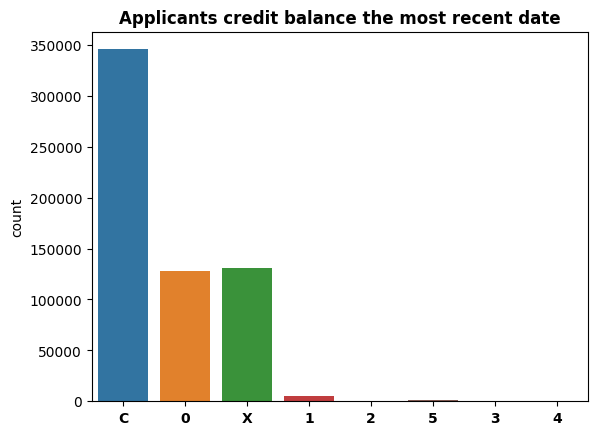

In [34]:
sns.countplot(x=df_bureau_balance[df_bureau_balance['MONTHS_BALANCE']==0]['STATUS'])\
    .set_title('Applicants credit balance the most recent date', weight='bold')
plt.gca().set_xticklabels(plt.gca().get_xticklabels(), weight='bold')
plt.xlabel('')
plt.show()

Looking at the most up-to-date information available at the time of the application:
* Majority of credit balance is C (Closed). It indicates that the credit balance has been fully paid off and the credit account has been closed.
* Some credit balances are (0). This value typically represents "No credit balance" or "Zero balance." It indicates that there is no outstanding balance on the credit account.

### Credit card balance

Credit card balance data refers to information related to the outstanding balances and transactions associated with credit card accounts.

In [35]:
df_credit_card_balance = pd.read_csv(f'data/credit_card_balance.csv')
print(df_credit_card_balance.shape)
df_credit_card_balance.head()

(3840312, 23)


,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,AMT_PAYMENT_CURRENT,AMT_PAYMENT_TOTAL_CURRENT,AMT_RECEIVABLE_PRINCIPAL,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.970,135000,0.0,877.5,0.0,877.5,1700.325,1800.0,1800.0,0.000,0.000,0.000,0.0,1,0.0,1.0,35.0,Active,0,0
1,2582071,363914,-1,63975.555,45000,2250.0,2250.0,0.0,0.0,2250.000,2250.0,2250.0,60175.080,64875.555,64875.555,1.0,1,0.0,0.0,69.0,Active,0,0
2,1740877,371185,-7,31815.225,450000,0.0,0.0,0.0,0.0,2250.000,2250.0,2250.0,26926.425,31460.085,31460.085,0.0,0,0.0,0.0,30.0,Active,0,0
3,1389973,337855,-4,236572.110,225000,2250.0,2250.0,0.0,0.0,11795.760,11925.0,11925.0,224949.285,233048.970,233048.970,1.0,1,0.0,0.0,10.0,Active,0,0
4,1891521,126868,-1,453919.455,450000,0.0,11547.0,0.0,11547.0,22924.890,27000.0,27000.0,443044.395,453919.455,453919.455,0.0,1,0.0,1.0,101.0,Active,0,0


Looking at the most up-to-date information available at the time of the application:

In [36]:
t = df_credit_card_balance.groupby('SK_ID_CURR').max('MONTHS_BALANCE').reset_index('SK_ID_CURR')
print(t.shape)
t.describe().round(1).iloc[:, 2:]

(103558, 22)


,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,AMT_PAYMENT_CURRENT,AMT_PAYMENT_TOTAL_CURRENT,AMT_RECEIVABLE_PRINCIPAL,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,SK_DPD,SK_DPD_DEF
count,103558.0,103558.0,103558.0,72194.0,103558.0,72194.0,72194.0,103558.0,72120.0,103558.0,103558.0,103558.0,103558.0,72194.0,103558.0,72194.0,72194.0,103558.0,103558.0,103558.0
mean,-1.5,142297.9,249504.9,104865.0,98414.1,9531.0,44243.2,7149.7,118953.7,81265.7,135867.9,141272.4,141288.1,3.9,6.7,0.1,6.5,16.0,16.4,0.8
std,0.7,171325.5,201189.1,107106.1,121914.9,48900.2,83517.7,8609.2,149819.4,135025.3,164643.6,170190.6,170193.1,3.6,10.6,0.4,11.8,21.5,142.0,26.2
min,-12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,-2.0,0.0,112500.0,27000.0,0.0,0.0,0.0,0.0,22500.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,-1.0,96107.2,180000.0,90000.0,67500.0,0.0,7408.5,4760.3,65250.0,23436.0,90000.0,95477.3,95513.5,3.0,3.0,0.0,1.0,7.0,0.0,0.0
75%,-1.0,194612.5,315000.0,137250.0,139050.0,0.0,58455.0,9554.6,157500.0,107513.7,180000.0,193915.3,193994.4,5.0,8.0,0.0,8.0,23.0,0.0,0.0
max,-1.0,1505902.2,1350000.0,2115000.0,2287098.3,1529847.0,2239274.2,202882.0,4289207.4,4278315.7,1472316.8,1493338.2,1493338.2,51.0,165.0,12.0,165.0,120.0,3260.0,3260.0


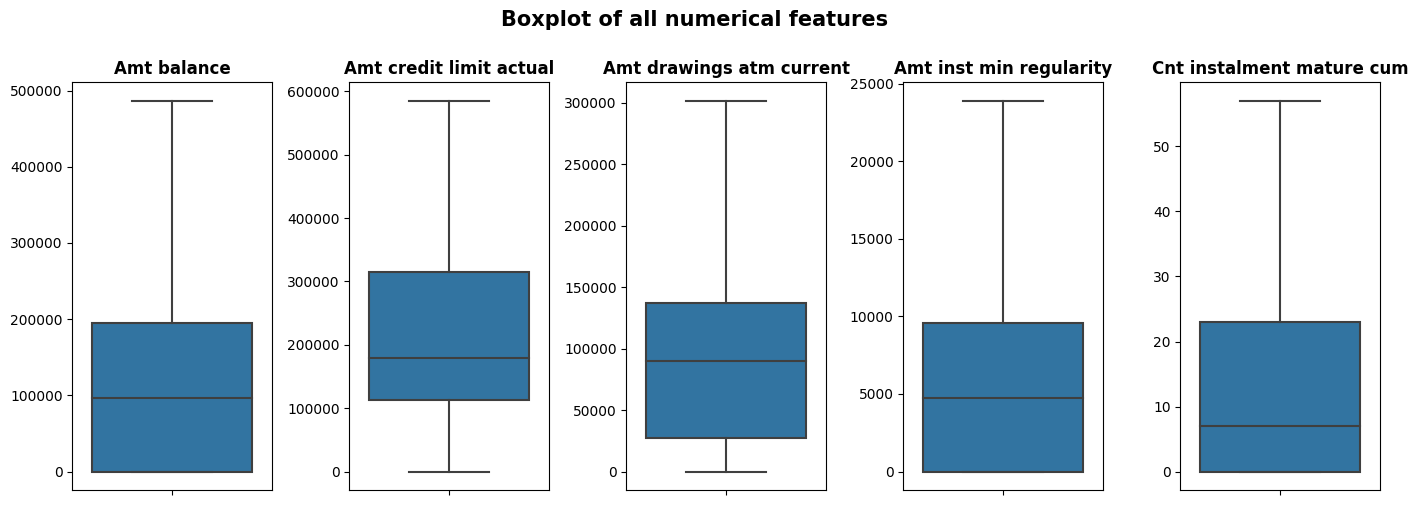

In [37]:
numeric_columns = ['AMT_BALANCE',
       'AMT_CREDIT_LIMIT_ACTUAL', 'AMT_DRAWINGS_ATM_CURRENT',
       'AMT_INST_MIN_REGULARITY','CNT_INSTALMENT_MATURE_CUM']
make_multiple_boxplots(t, numeric_columns, '', [14, 5], 5, '')

* The majority of accounts have account balance between 0 and 200,000 with median being 100,000.
* The credit limit assigned to each customer is mostly between 100,000 and 300,000, with median being 180,000.
* The total amount drawn by customers, including withdrawals from ATMs, point-of-sale transactions, and other sources is mostly between 30,000 and 140,000, median 90,000. 
* The minimum installment amount required to be paid regularly by customers is mostly between 0 and 10,000, median being 5,000.
* The number of installments customers have successfully completed is mostly between 0 and 23, median being 8.

### Installments payments

The dataset contains information related to the installment payments made by individuals or businesses for their loans or credit agreements.

In [38]:
installments_payments = pd.read_csv(f'data/installments_payments.csv')
print(installments_payments.shape)
installments_payments.head()


(13605401, 8)


,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.360,6948.360
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525,1716.525
2,2085231,193053,2.0,1,-63.0,-63.0,25425.000,25425.000
3,2452527,199697,1.0,3,-2418.0,-2426.0,24350.130,24350.130
4,2714724,167756,1.0,2,-1383.0,-1366.0,2165.040,2160.585


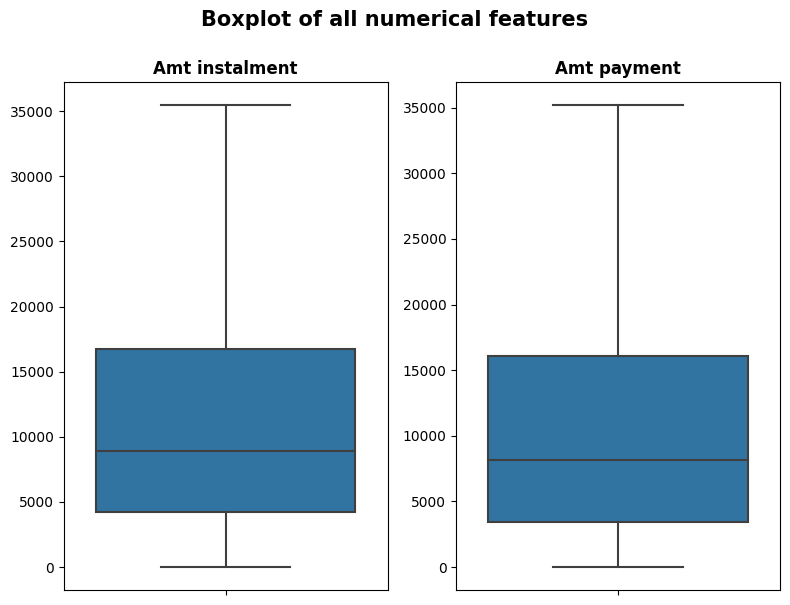

In [39]:
numeric_columns = ['AMT_INSTALMENT', 'AMT_PAYMENT']
make_multiple_boxplots(installments_payments, numeric_columns, '', [8, 6], 2, '')

The amount of payment slightly smaller than amount of the installment (agreed-upon amount).

### POS CASH balance

The dataset provides insights into the POS (Point-Of-Sale) cash balances, installment information, and payment behavior for previous loan or credit agreements.

In [40]:
POS_CASH_balance = pd.read_csv(f'data/POS_CASH_balance.csv')
print(POS_CASH_balance.shape)
POS_CASH_balance.head()

(10001358, 8)


,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31,48.0,45.0,Active,0,0
1,1715348,367990,-33,36.0,35.0,Active,0,0
2,1784872,397406,-32,12.0,9.0,Active,0,0
3,1903291,269225,-35,48.0,42.0,Active,0,0
4,2341044,334279,-35,36.0,35.0,Active,0,0


Taking the latest month recorded for each customer:

In [41]:
t = POS_CASH_balance.groupby('SK_ID_CURR').max('MONTHS_BALANCE').reset_index('SK_ID_CURR')
print(t.shape)
t.describe().round(1).iloc[:, 2:]

(337252, 7)


,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,SK_DPD,SK_DPD_DEF
count,337252.0,337224.0,337224.0,337252.0,337252.0
mean,-12.6,20.4,20.3,15.3,1.5
std,18.6,13.9,14.0,151.3,32.3
min,-96.0,1.0,0.0,0.0,0.0
25%,-15.0,12.0,12.0,0.0,0.0
50%,-4.0,12.0,12.0,0.0,0.0
75%,-2.0,24.0,24.0,0.0,0.0
max,-1.0,92.0,85.0,4231.0,3595.0


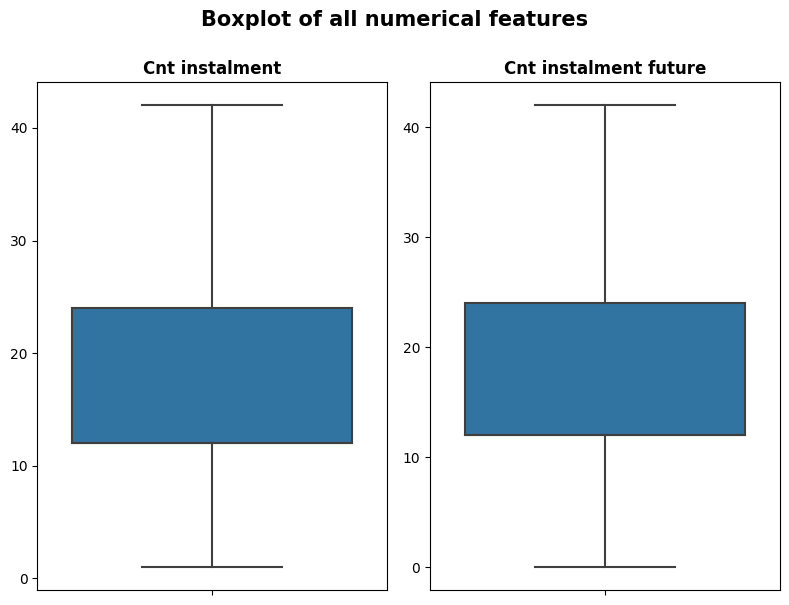

In [42]:
numeric_columns = ['CNT_INSTALMENT', 'CNT_INSTALMENT_FUTURE']
make_multiple_boxplots(t, numeric_columns, '', [8, 6], 2, '')

The borrowers have been making regular payments according to the agreed-upon installment plan, resulting in the completion of a significant portion of the scheduled installments.

DPD - days past due for the previous loan or credit agreement (the payment was delayed beyond the due date).

## Creating features

In [44]:
application_test['test'] = 1
application_train['test'] = 0
df = pd.concat([application_test, application_train], axis=0)
print(df.shape)
df.head()

(356251, 128)


,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,test,TARGET,YEARS_BIRTH,YEARS_EMPLOYED,YEARS_REGISTRATION,YEARS_ID_PUBLISH,YEARS_LAST_PHONE_CHANGE
0,100001,Cash loans,F,N,Y,0,135000.0,568800.0,20560.5,450000.0,Unaccompanied,Working,Higher education,Married,House / apartment,0.018850,-19241.0,-2329.0,-5170.0,-812.0,NaN,1,1,0,1,0,1,NaN,2.0,2,2,TUESDAY,18,0,0,0,0,0,0,Kindergarten,0.752614,0.789654,0.159520,0.0660,0.0590,0.9732,NaN,NaN,NaN,0.1379,0.125,NaN,NaN,NaN,0.0505,NaN,NaN,0.0672,0.0612,0.9732,NaN,NaN,NaN,0.1379,0.125,NaN,NaN,NaN,0.0526,NaN,NaN,0.0666,0.0590,0.9732,NaN,NaN,NaN,0.1379,0.125,NaN,NaN,NaN,0.0514,NaN,NaN,NaN,block of flats,0.0392,"Stone, brick",No,0.0,0.0,0.0,0.0,-1740.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,1,NaN,NaN,NaN,NaN,NaN,NaN
1,100005,Cash loans,M,N,Y,0,99000.0,222768.0,17370.0,180000.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.035792,-18064.0,-4469.0,-9118.0,-1623.0,NaN,1,1,0,1,0,0,Low-skill Laborers,2.0,2,2,FRIDAY,9,0,0,0,0,0,0,Self-employed,0.564990,0.291656,0.432962,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,3.0,1,NaN,NaN,NaN,NaN,NaN,NaN
2,100013,Cash loans,M,Y,Y,0,202500.0,663264.0,69777.0,630000.0,NaN,Working,Higher education,Married,House / apartment,0.019101,-20038.0,-4458.0,-2175.0,-3503.0,5.0,1,1,0,1,0,0,Drivers,2.0,2,2,MONDAY,14,0,0,0,0,0,0,Transport: type 3,NaN,0.699787,0.610991,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,-856.0,0,0,0,0,0,0,1,0,0,0

Taking the most important columns train and test data:

In [47]:
columns_to_drop = ['OBS_30_CNT_SOCIAL_CIRCLE', 'OBS_60_CNT_SOCIAL_CIRCLE',  
                   'HOUR_APPR_PROCESS_START', 'DEF_60_CNT_SOCIAL_CIRCLE', 
                   'FLAG_MOBIL','FLAG_EMP_PHONE' ,'FLAG_WORK_PHONE', 
                   'FLAG_CONT_MOBILE', 
                   'FLAG_PHONE', 'FLAG_EMAIL', 'NONLIVINGAPARTMENTS_MODE',
                   'CNT_CHILDREN', 'CNT_FAM_MEMBERS', 'HOUR_APPR_PROCESS_START',
                   'NONLIVINGAPARTMENTS_MEDI', 'NONLIVINGAPARTMENTS_AVG', 
                   'ELEVATORS_MEDI', 'ELEVATORS_AVG', 'ELEVATORS_MODE',
                   'FLOORSMIN_MEDI', 'FLOORSMIN_AVG', 'FLOORSMIN_MODE',
                   'LANDAREA_MEDI', 'LANDAREA_AVG', 'LANDAREA_MODE',
                   'LIVINGAPARTMENTS_MEDI', 'LIVINGAPARTMENTS_AVG', 'LIVINGAPARTMENTS_MODE',
                   'YEARS_BUILD_MEDI', 'YEARS_BUILD_AVG', 'YEARS_BUILD_MODE',
                   'FLAG_DOCUMENT_2', 'FLAG_DOCUMENT_4', 'FLAG_DOCUMENT_5', 
                   'FLAG_DOCUMENT_6', 'FLAG_DOCUMENT_10', 'FLAG_DOCUMENT_14', 
                   'FLAG_DOCUMENT_7', 'FLAG_DOCUMENT_8', 'FLAG_DOCUMENT_9', 
                   'FLAG_DOCUMENT_11', 'FLAG_DOCUMENT_12', 'FLAG_DOCUMENT_13', 
                   'FLAG_DOCUMENT_15', 'FLAG_DOCUMENT_16', 'FLAG_DOCUMENT_17', 
                   'FLAG_DOCUMENT_19', 'FLAG_DOCUMENT_20', 'FLAG_DOCUMENT_21',
                   'APARTMENTS_AVG', 'APARTMENTS_MEDI', 'APARTMENTS_MODE',
                   'BASEMENTAREA_AVG', 'BASEMENTAREA_MEDI', 'COMMONAREA_MEDI',
                   'COMMONAREA_MODE', 'ENTRANCES_AVG', 'ENTRANCES_MEDI', 'FLOORSMAX_AVG',
                   'ENTRANCES_MEDI,' 'FLOORSMAX_AVG', 'FLOORSMAX_MODE',
                   'LIVINGAREA_AVG', 'LIVINGAREA_MODE', 'NONLIVINGAREA_AVG',
                   'TOTALAREA_MODE', 'YEARS_BEGINEXPLUATATION_AVG', 'FLAG_DOCUMENT_18',
                   'YEARS_BEGINEXPLUATATION_MEDI', 'NONLIVINGAREA_MEDI'
                   'LIVE_CITY_NOT_WORK_CITY', 'LIVE_REGION_NOT_WORK_REGION']

df = df.drop(columns_to_drop, axis=1, errors='ignore')
print(df.shape)
df.head()

(356251, 65)


,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,OCCUPATION_TYPE,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,COMMONAREA_AVG,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,ENTRANCES_MODE,NONLIVINGAREA_MODE,FLOORSMAX_MEDI,LIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,DEF_30_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_3,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,test,TARGET,YEARS_BIRTH,YEARS_EMPLOYED,YEARS_REGISTRATION,YEARS_ID_PUBLISH,YEARS_LAST_PHONE_CHANGE,pos_SK_ID_PREV,pos_MONTHS_BALANCE,pos_CNT_INSTALMENT,pos_CNT_INSTALMENT_FUTURE,pos_SK_DPD,pos_SK_DPD_DEF
0,100001,Cash loans,F,N,Y,135000.0,568800.0,20560.5,450000.0,Unaccompanied,Working,Higher education,Married,House / apartment,0.018850,-19241.0,-2329.0,-5170.0,-812.0,NaN,NaN,2,2,TUESDAY,0,0,0,0,Kindergarten,0.752614,0.789654,0.159520,NaN,0.0612,0.9732,0.1379,NaN,0.125,0.0514,NaN,block of flats,"Stone, brick",No,0.0,-1740.0,1,0.0,0.0,0.0,0.0,0.0,0.0,1,NaN,NaN,NaN,NaN,NaN,NaN,1851984.0,-53.0,4.0,4.0,7.0,7.0
1,100005,Cash loans,M,N,Y,99000.0,222768.0,17370.0,180000.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.035792,-18064.0,-4469.0,-9118.0,-1623.0,NaN,Low-skill Laborers,2,2,FRIDAY,0,0,0,0,Self-employed,0.564990,0.291656,0.432962,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1,0.0,0.0,0.0,0.0,0.0,3.0,1,NaN,NaN,NaN,NaN,NaN,NaN,2495675.0,-15.0,12.0,12.0,0.0,0.0
2,100013,Cash loans,M,Y,Y,202500.0,663264.0,69777.0,630000.0,NaN,Working,Higher education,Married,House / apartment,0.019101,-20038.0,-4458.0,-2175.0,-3503.0,5.0,Drivers,2,2,MONDAY,0,0,0,0,Transport: type 3,NaN,0.699787,0.610991,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,-856.0,0,0.0,0.0,0.0,0.0,1.0,4.0,1,NaN,NaN,NaN,NaN,NaN,NaN,1865796.0,-3.0,36.0,36.0,18.0,0.0
3,100028,Cash loans,F,N,Y,315000.0,1575000.0,49018.5,1575000.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.026392,-13976.0,-1866.0,-2000.0,-4208.0,NaN,Sales staff,2,2,WEDNESDAY,0,0,0,0,Business Entity Type 3,0.525734,0.509677,0.612704,0.1165,0.2049,0.9970,0.2759,0.0847,0.375,0.3739,reg oper account,block of flats,Panel,No,0.0,-1805.0,1,0.0,0.0,0.0,0.0,0.0,3.0,1,NaN,NaN,NaN,NaN,NaN,NaN,2829726.0,-20.0,24.0,24.0,0.0,0.0
4,100038,Cash loans,M,Y,N,180000.0,625500.0,32067.0,625500.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.010032,-13040.0,-2191.0,-4000.0,-4262.0,16.0,NaN,2,2,FRIDAY,0,0,0,1,Business Entity Type 3,0.202145,0.425687,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,-821.0,1,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,2327930.0,-15.0,12.0,12.0,0.0,0.0


Joining the latest POS (point-of-sale) CASH balance data:

In [46]:
t = POS_CASH_balance.groupby('SK_ID_CURR').max('MONTHS_BALANCE').reset_index()
t.columns = ['pos_' + name if name != 'SK_ID_CURR' else name for name in t.columns]
df = df.merge(t, how='left', on='SK_ID_CURR')

print(df.shape)
df.head()

(356251, 65)


,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,OCCUPATION_TYPE,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,COMMONAREA_AVG,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,ENTRANCES_MODE,NONLIVINGAREA_MODE,FLOORSMAX_MEDI,LIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,DEF_30_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_3,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,test,TARGET,YEARS_BIRTH,YEARS_EMPLOYED,YEARS_REGISTRATION,YEARS_ID_PUBLISH,YEARS_LAST_PHONE_CHANGE,pos_SK_ID_PREV,pos_MONTHS_BALANCE,pos_CNT_INSTALMENT,pos_CNT_INSTALMENT_FUTURE,pos_SK_DPD,pos_SK_DPD_DEF
0,100001,Cash loans,F,N,Y,135000.0,568800.0,20560.5,450000.0,Unaccompanied,Working,Higher education,Married,House / apartment,0.018850,-19241.0,-2329.0,-5170.0,-812.0,NaN,NaN,2,2,TUESDAY,0,0,0,0,Kindergarten,0.752614,0.789654,0.159520,NaN,0.0612,0.9732,0.1379,NaN,0.125,0.0514,NaN,block of flats,"Stone, brick",No,0.0,-1740.0,1,0.0,0.0,0.0,0.0,0.0,0.0,1,NaN,NaN,NaN,NaN,NaN,NaN,1851984.0,-53.0,4.0,4.0,7.0,7.0
1,100005,Cash loans,M,N,Y,99000.0,222768.0,17370.0,180000.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.035792,-18064.0,-4469.0,-9118.0,-1623.0,NaN,Low-skill Laborers,2,2,FRIDAY,0,0,0,0,Self-employed,0.564990,0.291656,0.432962,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1,0.0,0.0,0.0,0.0,0.0,3.0,1,NaN,NaN,NaN,NaN,NaN,NaN,2495675.0,-15.0,12.0,12.0,0.0,0.0
2,100013,Cash loans,M,Y,Y,202500.0,663264.0,69777.0,630000.0,NaN,Working,Higher education,Married,House / apartment,0.019101,-20038.0,-4458.0,-2175.0,-3503.0,5.0,Drivers,2,2,MONDAY,0,0,0,0,Transport: type 3,NaN,0.699787,0.610991,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,-856.0,0,0.0,0.0,0.0,0.0,1.0,4.0,1,NaN,NaN,NaN,NaN,NaN,NaN,1865796.0,-3.0,36.0,36.0,18.0,0.0
3,100028,Cash loans,F,N,Y,315000.0,1575000.0,49018.5,1575000.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.026392,-13976.0,-1866.0,-2000.0,-4208.0,NaN,Sales staff,2,2,WEDNESDAY,0,0,0,0,Business Entity Type 3,0.525734,0.509677,0.612704,0.1165,0.2049,0.9970,0.2759,0.0847,0.375,0.3739,reg oper account,block of flats,Panel,No,0.0,-1805.0,1,0.0,0.0,0.0,0.0,0.0,3.0,1,NaN,NaN,NaN,NaN,NaN,NaN,2829726.0,-20.0,24.0,24.0,0.0,0.0
4,100038,Cash loans,M,Y,N,180000.0,625500.0,32067.0,625500.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.010032,-13040.0,-2191.0,-4000.0,-4262.0,16.0,NaN,2,2,FRIDAY,0,0,0,1,Business Entity Type 3,0.202145,0.425687,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,-821.0,1,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN,NaN,NaN,NaN,2327930.0,-15.0,12.0,12.0,0.0,0.0


Joining the latest Credit Card balance data:

In [48]:
t = df_credit_card_balance.groupby('SK_ID_CURR').max('MONTHS_BALANCE').reset_index()
t.columns = ['cc_' + name if name != 'SK_ID_CURR' else name for name in t.columns]
df = df.merge(t, how='left', on='SK_ID_CURR')

print(df.shape)
df.head()

(356251, 86)


,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,OCCUPATION_TYPE,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,COMMONAREA_AVG,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,ENTRANCES_MODE,NONLIVINGAREA_MODE,FLOORSMAX_MEDI,LIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,DEF_30_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_3,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,test,TARGET,YEARS_BIRTH,YEARS_EMPLOYED,YEARS_REGISTRATION,YEARS_ID_PUBLISH,YEARS_LAST_PHONE_CHANGE,pos_SK_ID_PREV,pos_MONTHS_BALANCE,pos_CNT_INSTALMENT,pos_CNT_INSTALMENT_FUTURE,pos_SK_DPD,pos_SK_DPD_DEF,cc_SK_ID_PREV,cc_MONTHS_BALANCE,cc_AMT_BALANCE,cc_AMT_CREDIT_LIMIT_ACTUAL,cc_AMT_DRAWINGS_ATM_CURRENT,cc_AMT_DRAWINGS_CURRENT,cc_AMT_DRAWINGS_OTHER_CURRENT,cc_AMT_DRAWINGS_POS_CURRENT,cc_AMT_INST_MIN_REGULARITY,cc_AMT_PAYMENT_CURRENT,cc_AMT_PAYMENT_TOTAL_CURRENT,cc_AMT_RECEIVABLE_PRINCIPAL,cc_AMT_RECIVABLE,cc_AMT_TOTAL_RECEIVABLE,cc_CNT_DRAWINGS_ATM_CURRENT,cc_CNT_DRAWINGS_CURRENT,cc_CNT_DRAWINGS_OTHER_CURRENT,cc_CNT_DRAWINGS_POS_CURRENT,cc_CNT_INSTALMENT_MATURE_CUM,cc_SK_DPD,cc_SK_DPD_DEF
0,100001,Cash loans,F,N,Y,135000.0,568800.0,20560.5,450000.0,Unaccompanied,Working,Higher education,Married,House / apartment,0.018850,-19241.0,-2329.0,-5170.0,-812.0,NaN,NaN,2,2,TUESDAY,0,0,0,0,Kindergarten,0.752614,0.789654,0.159520,NaN,0.0612,0.9732,0.1379,NaN,0.125,0.0514,NaN,block of flats,"Stone, brick",No,0.0,-1740.0,1,0.0,0.0,0.0,0.0,0.0,0.0,1,NaN,NaN,NaN,NaN,NaN,NaN,1851984.0,-53.0,4.0,4.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,100005,Cash loans,M,N,Y,99000.0,222768.0,17370.0,180000.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.035792,-18064.0,-4469.0,-9118.0,-1623.0,NaN,Low-skill Laborers,2,2,FRIDAY,0,0,0,0,Self-employed,0.564990,0.291656,0.432962,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1,0.0,0.0,0.0,0.0,0.0,3.0,1,NaN,NaN,NaN,NaN,NaN,NaN,2495675.0,-15.0,12.0,12.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,100013,Cash loans,M,Y,Y,202500.0,663264.0,69777.0,630000.0,NaN,Working,Higher education,Married,House / apartment,0.019101,-20038.0,-4458.0,-2175.0,-3503.0,5.0,Drivers,2,2,MONDAY,0,0,0,0,Transport: type 3,NaN,0.699787,0.610991,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,-856.0,0,0.0,0.0,0.0,0.0,1.0,4.0,1,NaN,NaN,NaN,NaN,NaN,NaN,1865796.0,-3.0,36.0,36.0,18.0,0.0,2038692.0,-1.0,161420.220,157500.0,157500.0,157500.00,0.0,0.00,7875.0,153675.0,153675.0,157500.000,161420.220,161420.220,7.0,7.0,0.0,0.0,22.0,1.0,1.0
3,100028,Cash loans,F,N,Y,315000.0,1575000.0,49018.5,1575000.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.026392,-13976.0,-1866.0,-2000.0,-4208.0,NaN,Sales staff,2,2,WEDNESDAY,0,0,0,0,Business Entity Type 3,0.525734,0.509677,0.612704,0.1165,0.2049,0.9970,0.2759,0.0847,0.375,0.3739,reg oper account,block of flats,Panel,No,0.0,-1805.0,1,0.0,0.0,0.0,0.0,0.0,3.0,1,NaN,NaN,NaN,NaN,NaN,NaN,2829726.0,-20.0,24.0,24.0,0.0,0.0,1914954.0,-1.0,37335.915,225000.0,18000.0,22823.55,0.0,22823.55,11250.0,15750.0,15750.0,36270.675,36980.415,36980.415,1.0,12.0,0.0,12.0,35.0,0.0,0.0
4,100038,Cash loans,M,Y,N,180000.0,625500.0,32067.0,625500.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.010032,-13040.0,-2191.0,-4000.0,-4262.0,16.0,NaN,2,2,FRIDAY,0,0,0,

Joining the latest data of bureau (customer's credit history), also adding the mean value per customer of all numerical columns:

In [49]:
t1 = df_bureau.groupby('SK_ID_CURR').mean().reset_index()
t2 = df_bureau.groupby('SK_ID_CURR')['SK_ID_BUREAU'].count()\
    .reset_index(name='count_bureau_records')
t3 = df_bureau.groupby('SK_ID_CURR').max('DAYS_CREDIT').reset_index()

t1.columns = ['b_mean_' + name for name in t1.columns]
t2.columns = ['b_' + name for name in t2.columns]
t3.columns = ['b_last_' + name for name in t3.columns]

df = df.merge(t1, how='left', left_on='SK_ID_CURR', right_on='b_mean_SK_ID_CURR')\
    .merge(t2, how='left', left_on='SK_ID_CURR', right_on='b_SK_ID_CURR')\
    .merge(t3, how='left', left_on='SK_ID_CURR', right_on='b_last_SK_ID_CURR')
print(df.shape)
df.head()

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.


(356251, 116)


,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,OCCUPATION_TYPE,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,COMMONAREA_AVG,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,ENTRANCES_MODE,NONLIVINGAREA_MODE,FLOORSMAX_MEDI,LIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,DEF_30_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_3,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,test,TARGET,YEARS_BIRTH,YEARS_EMPLOYED,YEARS_REGISTRATION,YEARS_ID_PUBLISH,YEARS_LAST_PHONE_CHANGE,pos_SK_ID_PREV,pos_MONTHS_BALANCE,pos_CNT_INSTALMENT,pos_CNT_INSTALMENT_FUTURE,pos_SK_DPD,pos_SK_DPD_DEF,cc_SK_ID_PREV,cc_MONTHS_BALANCE,cc_AMT_BALANCE,cc_AMT_CREDIT_LIMIT_ACTUAL,cc_AMT_DRAWINGS_ATM_CURRENT,cc_AMT_DRAWINGS_CURRENT,cc_AMT_DRAWINGS_OTHER_CURRENT,cc_AMT_DRAWINGS_POS_CURRENT,cc_AMT_INST_MIN_REGULARITY,cc_AMT_PAYMENT_CURRENT,cc_AMT_PAYMENT_TOTAL_CURRENT,cc_AMT_RECEIVABLE_PRINCIPAL,cc_AMT_RECIVABLE,cc_AMT_TOTAL_RECEIVABLE,cc_CNT_DRAWINGS_ATM_CURRENT,cc_CNT_DRAWINGS_CURRENT,cc_CNT_DRAWINGS_OTHER_CURRENT,cc_CNT_DRAWINGS_POS_CURRENT,cc_CNT_INSTALMENT_MATURE_CUM,cc_SK_DPD,cc_SK_DPD_DEF,b_mean_SK_ID_CURR,b_mean_SK_ID_BUREAU,b_mean_DAYS_CREDIT,b_mean_CREDIT_DAY_OVERDUE,b_mean_DAYS_CREDIT_ENDDATE,b_mean_DAYS_ENDDATE_FACT,b_mean_AMT_CREDIT_MAX_OVERDUE,b_mean_CNT_CREDIT_PROLONG,b_mean_AMT_CREDIT_SUM,b_mean_AMT_CREDIT_SUM_DEBT,b_mean_AMT_CREDIT_SUM_LIMIT,b_mean_AMT_CREDIT_SUM_OVERDUE,b_mean_DAYS_CREDIT_UPDATE,b_mean_AMT_ANNUITY,b_SK_ID_CURR,b_count_bureau_records,b_last_SK_ID_CURR,b_last_SK_ID_BUREAU,b_last_DAYS_CREDIT,b_last_CREDIT_DAY_OVERDUE,b_last_DAYS_CREDIT_ENDDATE,b_last_DAYS_ENDDATE_FACT,b_last_AMT_CREDIT_MAX_OVERDUE,b_last_CNT_CREDIT_PROLONG,b_last_AMT_CREDIT_SUM,b_last_AMT_CREDIT_SUM_DEBT,b_last_AMT_CREDIT_SUM_LIMIT,b_last_AMT_CREDIT_SUM_OVERDUE,b_last_DAYS_CREDIT_UPDATE,b_last_AMT_ANNUITY
0,100001,Cash loans,F,N,Y,135000.0,568800.0,20560.5,450000.0,Unaccompanied,Working,Higher education,Married,House / apartment,0.018850,-19241.0,-2329.0,-5170.0,-812.0,NaN,NaN,2,2,TUESDAY,0,0,0,0,Kindergarten,0.752614,0.789654,0.159520,NaN,0.0612,0.9732,0.1379,NaN,0.125,0.0514,NaN,block of flats,"Stone, brick",No,0.0,-1740.0,1,0.0,0.0,0.0,0.0,0.0,0.0,1,NaN,NaN,NaN,NaN,NaN,NaN,1851984.0,-53.0,4.0,4.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100001.0,5896633.00,-735.000000,0.0,82.428571,-825.500000,NaN,0.0,207623.571429,85240.928571,0.000000,0.0,-93.142857,3545.357143,100001.0,7.0,100001.0,5896636.0,-49.0,0.0,1778.0,-544.0,NaN,0.0,378000.0,373239.0,0.00,0.0,-6.0,10822.50
1,100005,Cash loans,M,N,Y,99000.0,222768.0,17370.0,180000.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.035792,-18064.0,-4469.0,-9118.0,-1623.0,NaN,Low-skill Laborers,2,2,FRIDAY,0,0,0,0,Self-employed,0.564990,0.291656,0.432962,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1,0.0,0.0,0.0,0.0,0.0,3.0,1,NaN,NaN,NaN,NaN,NaN,NaN,2495675.0,-15.0,12.0,12.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100005.0,6735201.00,-190.666667,0.0,439.333333,-123.000000,0.0,0.0,219042.000000,189469.500000,0.000000,0.0,-54.333333,1420.500000,100005.0,3.0,100005.0,6735202.0,-62.0,0.0,1324.0,-123.0,0.0,0.0,568800.0,543087.0,0.00,0.0,-11.0,4261.50
2,100013,Cash loans,M,Y,Y,202500.0,663264.0,69777.0,630000.0,NaN,Working,Higher education,Married,House / apartment,0.019101,-20038.0,-4458.0,

Joining previous applications data: <br>

In [56]:
df_previous_application['credit_diff'] = \
    df_previous_application['AMT_APPLICATION'] - df_previous_application['AMT_CREDIT']
df_previous_application['due_date_diff'] = \
    df_previous_application['DAYS_LAST_DUE_1ST_VERSION'] - df_previous_application['DAYS_LAST_DUE']

t1 = df_previous_application['SK_ID_CURR'] \
    .value_counts().round(1).to_frame(name='applications_count').reset_index() \
    .rename(columns={'index': 'SK_ID_CURR'})

# Approved, Canceled, Refused application count
t2 = df_previous_application.groupby(['SK_ID_CURR', 'NAME_CONTRACT_STATUS'])\
    .size().reset_index(name='count') \
    .pivot(index='SK_ID_CURR', columns='NAME_CONTRACT_STATUS', values='count') \
    .reset_index().fillna(0)

selected_columns = ['AMT_ANNUITY', 'AMT_APPLICATION', 'AMT_CREDIT', 
                    'AMT_DOWN_PAYMENT', 'AMT_GOODS_PRICE', 'CNT_PAYMENT', 
                    'DAYS_DECISION', 'credit_diff', 'due_date_diff']
t3 = df_previous_application.groupby('SK_ID_CURR')[selected_columns].mean().reset_index()

t1.columns = ['a_' + name for name in t1.columns]
t2.columns = ['a_' + name for name in t2.columns]
t3.columns = ['a_' + name for name in t3.columns]

df = df.merge(t1, how='left', left_on='SK_ID_CURR', right_on='a_SK_ID_CURR') \
    .merge(t2, how='left', left_on='SK_ID_CURR', right_on='a_SK_ID_CURR') \
    .merge(t3, how='left', left_on='SK_ID_CURR', right_on='a_SK_ID_CURR')
df.drop(columns=['a_SK_ID_CURR'], inplace=True)
print(df.shape)
df.head()

(356251, 132)


,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,OCCUPATION_TYPE,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,COMMONAREA_AVG,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,ENTRANCES_MODE,NONLIVINGAREA_MODE,FLOORSMAX_MEDI,LIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,DEF_30_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_3,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,test,TARGET,YEARS_BIRTH,YEARS_EMPLOYED,YEARS_REGISTRATION,YEARS_ID_PUBLISH,YEARS_LAST_PHONE_CHANGE,pos_SK_ID_PREV,pos_MONTHS_BALANCE,pos_CNT_INSTALMENT,pos_CNT_INSTALMENT_FUTURE,pos_SK_DPD,pos_SK_DPD_DEF,cc_SK_ID_PREV,cc_MONTHS_BALANCE,cc_AMT_BALANCE,cc_AMT_CREDIT_LIMIT_ACTUAL,cc_AMT_DRAWINGS_ATM_CURRENT,cc_AMT_DRAWINGS_CURRENT,cc_AMT_DRAWINGS_OTHER_CURRENT,cc_AMT_DRAWINGS_POS_CURRENT,cc_AMT_INST_MIN_REGULARITY,cc_AMT_PAYMENT_CURRENT,cc_AMT_PAYMENT_TOTAL_CURRENT,cc_AMT_RECEIVABLE_PRINCIPAL,cc_AMT_RECIVABLE,cc_AMT_TOTAL_RECEIVABLE,cc_CNT_DRAWINGS_ATM_CURRENT,cc_CNT_DRAWINGS_CURRENT,cc_CNT_DRAWINGS_OTHER_CURRENT,cc_CNT_DRAWINGS_POS_CURRENT,cc_CNT_INSTALMENT_MATURE_CUM,cc_SK_DPD,cc_SK_DPD_DEF,b_mean_SK_ID_CURR,b_mean_SK_ID_BUREAU,b_mean_DAYS_CREDIT,b_mean_CREDIT_DAY_OVERDUE,b_mean_DAYS_CREDIT_ENDDATE,b_mean_DAYS_ENDDATE_FACT,b_mean_AMT_CREDIT_MAX_OVERDUE,b_mean_CNT_CREDIT_PROLONG,b_mean_AMT_CREDIT_SUM,b_mean_AMT_CREDIT_SUM_DEBT,b_mean_AMT_CREDIT_SUM_LIMIT,b_mean_AMT_CREDIT_SUM_OVERDUE,b_mean_DAYS_CREDIT_UPDATE,b_mean_AMT_ANNUITY,b_SK_ID_CURR,b_count_bureau_records,b_last_SK_ID_CURR,b_last_SK_ID_BUREAU,b_last_DAYS_CREDIT,b_last_CREDIT_DAY_OVERDUE,b_last_DAYS_CREDIT_ENDDATE,b_last_DAYS_ENDDATE_FACT,b_last_AMT_CREDIT_MAX_OVERDUE,b_last_CNT_CREDIT_PROLONG,b_last_AMT_CREDIT_SUM,b_last_AMT_CREDIT_SUM_DEBT,b_last_AMT_CREDIT_SUM_LIMIT,b_last_AMT_CREDIT_SUM_OVERDUE,b_last_DAYS_CREDIT_UPDATE,b_last_AMT_ANNUITY,a_SK_ID_CURR_x,a_applications_count,a_SK_ID_CURR_y,a_Approved,a_Canceled,a_Refused,a_Unused offer,a_AMT_ANNUITY,a_AMT_APPLICATION,a_AMT_CREDIT,a_AMT_DOWN_PAYMENT,a_AMT_GOODS_PRICE,a_CNT_PAYMENT,a_DAYS_DECISION,a_credit_diff,a_due_date_diff
0,100001,Cash loans,F,N,Y,135000.0,568800.0,20560.5,450000.0,Unaccompanied,Working,Higher education,Married,House / apartment,0.018850,-19241.0,-2329.0,-5170.0,-812.0,NaN,NaN,2,2,TUESDAY,0,0,0,0,Kindergarten,0.752614,0.789654,0.159520,NaN,0.0612,0.9732,0.1379,NaN,0.125,0.0514,NaN,block of flats,"Stone, brick",No,0.0,-1740.0,1,0.0,0.0,0.0,0.0,0.0,0.0,1,NaN,NaN,NaN,NaN,NaN,NaN,1851984.0,-53.0,4.0,4.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100001.0,5896633.00,-735.000000,0.0,82.428571,-825.500000,NaN,0.0,207623.571429,85240.928571,0.000000,0.0,-93.142857,3545.357143,100001.0,7.0,100001.0,5896636.0,-49.0,0.0,1778.0,-544.0,NaN,0.0,378000.0,373239.0,0.00,0.0,-6.0,10822.50,100001.0,1.0,100001.0,1.0,0.0,0.0,0.0,3951.000,24835.50,23787.000,2520.0,24835.5,8.000000,-1740.0,1048.500,120.0
1,100005,Cash loans,M,N,Y,99000.0,222768.0,17370.0,180000.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.035792,-18064.0,-4469.0,-9118.0,-1623.0,NaN,Low-skill Laborers,2,2,FRIDAY,0,0,0,0,Self-employed,0.564990,0.291656,0.432962,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,1,0.0,0.0,0.0,0.0,0.0,3.0,1,NaN,NaN,NaN,NaN,NaN,NaN,2495675.0,-15.0,12.0,12.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100005.0,6735201.00,-190.

Additional features were calculated:
* df_previous_application['credit_diff'] the difference between the requested loan amount and the actual credited amount
* df_previous_application['due_date_diff'] shows if there was an extension in the due date between the initial version and the final version of the loan.

Joining the average of installment payments data:

In [57]:
installments_payments['days_past_due'] = \
    installments_payments['DAYS_ENTRY_PAYMENT'] - installments_payments['DAYS_INSTALMENT']
installments_payments['overpaid_amt'] = \
    installments_payments['AMT_PAYMENT'] - installments_payments['AMT_INSTALMENT']

t1 = installments_payments.groupby('SK_ID_CURR').mean().reset_index()
t2 = installments_payments.groupby('SK_ID_CURR')['SK_ID_PREV']\
    .count().reset_index(name='number_of_installments')
    
t1.columns = ['in_' + name for name in t1.columns]
t2.columns = ['in_' + name for name in t2.columns]

df = df.merge(t1, how='left', left_on='SK_ID_CURR', right_on='in_SK_ID_CURR')\
    .merge(t2, how='left', left_on='SK_ID_CURR', right_on='in_SK_ID_CURR')
print(df.shape)
df.head()

(356251, 144)


,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,OCCUPATION_TYPE,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,COMMONAREA_AVG,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,ENTRANCES_MODE,NONLIVINGAREA_MODE,FLOORSMAX_MEDI,LIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,DEF_30_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_3,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,test,TARGET,YEARS_BIRTH,YEARS_EMPLOYED,YEARS_REGISTRATION,YEARS_ID_PUBLISH,YEARS_LAST_PHONE_CHANGE,pos_SK_ID_PREV,pos_MONTHS_BALANCE,pos_CNT_INSTALMENT,pos_CNT_INSTALMENT_FUTURE,pos_SK_DPD,pos_SK_DPD_DEF,cc_SK_ID_PREV,cc_MONTHS_BALANCE,cc_AMT_BALANCE,cc_AMT_CREDIT_LIMIT_ACTUAL,cc_AMT_DRAWINGS_ATM_CURRENT,cc_AMT_DRAWINGS_CURRENT,cc_AMT_DRAWINGS_OTHER_CURRENT,cc_AMT_DRAWINGS_POS_CURRENT,cc_AMT_INST_MIN_REGULARITY,cc_AMT_PAYMENT_CURRENT,cc_AMT_PAYMENT_TOTAL_CURRENT,cc_AMT_RECEIVABLE_PRINCIPAL,cc_AMT_RECIVABLE,cc_AMT_TOTAL_RECEIVABLE,cc_CNT_DRAWINGS_ATM_CURRENT,cc_CNT_DRAWINGS_CURRENT,cc_CNT_DRAWINGS_OTHER_CURRENT,cc_CNT_DRAWINGS_POS_CURRENT,cc_CNT_INSTALMENT_MATURE_CUM,cc_SK_DPD,cc_SK_DPD_DEF,b_mean_SK_ID_CURR,b_mean_SK_ID_BUREAU,b_mean_DAYS_CREDIT,b_mean_CREDIT_DAY_OVERDUE,b_mean_DAYS_CREDIT_ENDDATE,b_mean_DAYS_ENDDATE_FACT,b_mean_AMT_CREDIT_MAX_OVERDUE,b_mean_CNT_CREDIT_PROLONG,b_mean_AMT_CREDIT_SUM,b_mean_AMT_CREDIT_SUM_DEBT,b_mean_AMT_CREDIT_SUM_LIMIT,b_mean_AMT_CREDIT_SUM_OVERDUE,b_mean_DAYS_CREDIT_UPDATE,b_mean_AMT_ANNUITY,b_SK_ID_CURR,b_count_bureau_records,b_last_SK_ID_CURR,b_last_SK_ID_BUREAU,b_last_DAYS_CREDIT,b_last_CREDIT_DAY_OVERDUE,b_last_DAYS_CREDIT_ENDDATE,b_last_DAYS_ENDDATE_FACT,b_last_AMT_CREDIT_MAX_OVERDUE,b_last_CNT_CREDIT_PROLONG,b_last_AMT_CREDIT_SUM,b_last_AMT_CREDIT_SUM_DEBT,b_last_AMT_CREDIT_SUM_LIMIT,b_last_AMT_CREDIT_SUM_OVERDUE,b_last_DAYS_CREDIT_UPDATE,b_last_AMT_ANNUITY,a_SK_ID_CURR_x,a_applications_count,a_SK_ID_CURR_y,a_Approved,a_Canceled,a_Refused,a_Unused offer,a_AMT_ANNUITY,a_AMT_APPLICATION,a_AMT_CREDIT,a_AMT_DOWN_PAYMENT,a_AMT_GOODS_PRICE,a_CNT_PAYMENT,a_DAYS_DECISION,a_credit_diff,a_due_date_diff,in_SK_ID_CURR_x,in_SK_ID_PREV,in_NUM_INSTALMENT_VERSION,in_NUM_INSTALMENT_NUMBER,in_DAYS_INSTALMENT,in_DAYS_ENTRY_PAYMENT,in_AMT_INSTALMENT,in_AMT_PAYMENT,in_days_past_due,in_overpaid_amt,in_SK_ID_CURR_y,in_number_of_installments
0,100001,Cash loans,F,N,Y,135000.0,568800.0,20560.5,450000.0,Unaccompanied,Working,Higher education,Married,House / apartment,0.018850,-19241.0,-2329.0,-5170.0,-812.0,NaN,NaN,2,2,TUESDAY,0,0,0,0,Kindergarten,0.752614,0.789654,0.159520,NaN,0.0612,0.9732,0.1379,NaN,0.125,0.0514,NaN,block of flats,"Stone, brick",No,0.0,-1740.0,1,0.0,0.0,0.0,0.0,0.0,0.0,1,NaN,NaN,NaN,NaN,NaN,NaN,1851984.0,-53.0,4.0,4.0,7.0,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100001.0,5896633.00,-735.000000,0.0,82.428571,-825.500000,NaN,0.0,207623.571429,85240.928571,0.000000,0.0,-93.142857,3545.357143,100001.0,7.0,100001.0,5896636.0,-49.0,0.0,1778.0,-544.0,NaN,0.0,378000.0,373239.0,0.00,0.0,-6.0,10822.50,100001.0,1.0,100001.0,1.0,0.0,0.0,0.0,3951.000,24835.50,23787.000,2520.0,24835.5,8.000000,-1740.0,1048.500,120.0,100001.0,1.576389e+06,1.142857,2.714286,-2187.714286,-2195.000000,5885.132143,5885.132143,-7.285714,0.000000,100001.0,7.0
1,100005,Cash loans,M,N,Y,99000.0,222768.0,17370.0,180000.0,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.035792,-18064.0,-4

Additional features were calculated:
* installments_payments['days_past_due'] - the difference in days between the actual payment date and the scheduled installment due date
* installments_payments['overpaid_amt'] - the difference between the actual payment made and the scheduled installment amount

### Dropping some features

Removing id columns:

In [58]:
columns_to_drop = [col for col in df.columns if 'SK_ID' in col][1:]
df = df.drop(columns_to_drop, axis=1, errors='ignore')
print(df.shape)

(356251, 132)


Removing the columns with more than 75% missing values:

In [59]:
df = df.dropna(thresh=len(df) * 0.25, axis=1)
print(df.shape)

(356251, 120)


Removing correlated, duplicate and constant features with Feature-Engine:

In [60]:
tr = SmartCorrelatedSelection(
    variables=None,
    method="pearson",
    threshold=0.9,
    missing_values="ignore",
    selection_method="variance",
    estimator=None,
)
Xt = tr.fit_transform(df)
cols_to_remove = tr.features_to_drop_
print('Number of columns removed: ', len(cols_to_remove), cols_to_remove)
df = df.drop(cols_to_remove, axis=1)

Number of columns removed:  12 ['AMT_GOODS_PRICE', 'REGION_RATING_CLIENT_W_CITY', 'pos_CNT_INSTALMENT', 'cc_AMT_INST_MIN_REGULARITY', 'cc_AMT_RECEIVABLE_PRINCIPAL', 'cc_AMT_RECIVABLE', 'cc_AMT_TOTAL_RECEIVABLE', 'b_mean_AMT_CREDIT_MAX_OVERDUE', 'a_AMT_APPLICATION', 'a_AMT_CREDIT', 'in_DAYS_ENTRY_PAYMENT', 'in_AMT_INSTALMENT']


In [61]:
tr = DropDuplicateFeatures(missing_values="ignore")
Xt = tr.fit_transform(df)
cols_to_remove = tr.features_to_drop_
print('Number of columns removed: ', len(cols_to_remove), cols_to_remove)

Number of columns removed:  0 set()


In [62]:
tr = DropConstantFeatures(tol=0.95, missing_values='ignore')
Xt = tr.fit_transform(df)
cols_to_remove = tr.features_to_drop_
print('Number of columns removed: ', len(cols_to_remove), cols_to_remove)
df = df.drop(cols_to_remove, axis=1)

Number of columns removed:  1 ['REG_REGION_NOT_LIVE_REGION']


Correlation between the target variable and the rest of the features in the dataframe:

In [63]:
df.corr(numeric_only=True)[['TARGET']]\
    .sort_values(by='TARGET', ascending=False).dropna().round(3)

,TARGET
TARGET,1.000
cc_CNT_DRAWINGS_CURRENT,0.101
b_mean_DAYS_CREDIT,0.090
YEARS_BIRTH,0.078
b_mean_DAYS_CREDIT_UPDATE,0.069
...,...
FLOORSMAX_MEDI,-0.044
YEARS_EMPLOYED,-0.045
EXT_SOURCE_1,-0.155
EXT_SOURCE_2,-0.160


## Prediction

In [30]:
numerical_cols = [var for var in df.columns if df[var].dtype != 'O']
categorical_cols = [var for var in df.columns if df[var].dtype == 'O']

In [31]:
print('Categorical columns:', len(categorical_cols), categorical_cols, 
      '\nNumerical columns:', len(numerical_cols), numerical_cols)

Categorical columns: 16 ['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE', 'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE', 'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE'] 
Numerical columns: 91 ['SK_ID_CURR', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'AMT_ANNUITY', 'REGION_POPULATION_RELATIVE', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_REGISTRATION', 'DAYS_ID_PUBLISH', 'OWN_CAR_AGE', 'REGION_RATING_CLIENT', 'REG_REGION_NOT_WORK_REGION', 'REG_CITY_NOT_LIVE_CITY', 'REG_CITY_NOT_WORK_CITY', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'COMMONAREA_AVG', 'BASEMENTAREA_MODE', 'YEARS_BEGINEXPLUATATION_MODE', 'ENTRANCES_MODE', 'NONLIVINGAREA_MODE', 'FLOORSMAX_MEDI', 'LIVINGAREA_MEDI', 'DEF_30_CNT_SOCIAL_CIRCLE', 'DAYS_LAST_PHONE_CHANGE', 'FLAG_DOCUMENT_3', 'AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_R

In [32]:
for col in categorical_cols:
    df[col] = df[col].astype('category')

In [33]:
X_train, X_test, y_train, y_test = \
    train_test_split(df[df['test']==0].drop(['TARGET', 'test'], axis=1), 
                     df[df['test']==0]['TARGET'], 
                     test_size=0.33, 
                     random_state=42, 
                     stratify=df[df['test']==0]['TARGET'])

### CatBoost

Creating column transformers and preprocessor:

In [34]:
numerical_cols = X_train.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = X_train.select_dtypes(include=['category', 'object']).columns

numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('to_string', FunctionTransformer(lambda x: x.astype(str)))
])
preprocessor_catboost = ColumnTransformer(
  transformers=[
    ('numerical', numerical_transformer, numerical_cols),
    ('categorical', categorical_transformer, categorical_cols),
])

Hyperparameter tuning with Optuna:

In [ ]:
train_x, valid_x, train_y, valid_y = train_test_split(X_train, y_train, test_size=0.25, stratify=y_train)

preprocessor_catboost.fit(train_x)
train_x = preprocessor_catboost.transform(train_x)
train_x = pd.DataFrame(train_x, columns=numerical_cols.tolist() + categorical_cols.tolist())
valid_x = preprocessor_catboost.transform(valid_x)
valid_x = pd.DataFrame(valid_x, columns=numerical_cols.tolist() + categorical_cols.tolist())

cat_features_index = [i for i, col in enumerate(train_x.columns) if col in categorical_cols]

train_pool = cb.Pool(data=train_x, label=train_y, cat_features=cat_features_index)
valid_pool = cb.Pool(data=valid_x, label=valid_y, cat_features=cat_features_index)

def objective(trial):
    param = {
        'objective': 'Logloss',
        'eval_metric': 'AUC',
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.3, log=True),
        'depth': trial.suggest_int('depth', 1, 8),
        'bootstrap_type': trial.suggest_categorical('bootstrap_type', ['Bernoulli', 'Poisson']),
        'subsample': trial.suggest_float('subsample', 0.4, 1.0),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 0.0, 1.0),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 20)
    }

    model = cb.CatBoostClassifier(iterations=1000, scale_pos_weight=11, **param)
    model.fit(train_pool, eval_set=valid_pool, early_stopping_rounds=100, verbose=100)

    y_pred = model.predict_proba(valid_pool)[:, 1]
    evaluation = metrics.roc_auc_score(valid_y, y_pred)
    return evaluation


my_study = optuna.create_study(direction='maximize')
my_study.optimize(objective, n_trials=30)
print("Number of finished trials: {}".format(len(my_study.trials)))

In [45]:
print("Best AUC-ROC score:",np.round(my_study.best_value,3))
params = my_study.best_params
params

{'learning_rate': 0.08303313912341105,
 'depth': 3,
 'bootstrap_type': 'Poisson',
 'subsample': 0.8315935212540188,
 'l2_leaf_reg': 0.0733571031023316,
 'min_child_samples': 3}

In [35]:
best_params = {'learning_rate': 0.08303313912341105,
                'depth': 3,
                'bootstrap_type': 'Poisson',
                'subsample': 0.8315935212540188,
                'l2_leaf_reg': 0.0733571031023316,
                'min_child_samples': 3}

Testing the model with the best hyperparameters:

In [ ]:
X_train_preprocessed = preprocessor_catboost.fit_transform(X_train)
X_test_preprocessed = preprocessor_catboost.transform(X_test)

X_train_preprocessed = pd.DataFrame(X_train_preprocessed, 
                                    columns = numerical_cols.tolist()+categorical_cols.tolist())
X_test_preprocessed = pd.DataFrame(X_test_preprocessed, 
                                   columns = numerical_cols.tolist()+categorical_cols.tolist())

cat_features_index = [i for i, col in enumerate(X_train_preprocessed.columns) if col in categorical_cols]

catboost_model = cb.CatBoostClassifier(**best_params, 
                                       objective='Logloss', task_type='GPU',
                                       eval_metric='AUC', scale_pos_weight=11)

train_pool = cb.Pool(data=X_train_preprocessed, 
                     label=y_train, 
                     cat_features=cat_features_index
)
catboost_model.fit(train_pool)
dill.dump(preprocessor_catboost, open('preprocessor_catboost.pkl', 'wb'))
dump(catboost_model, 'catboost_model.joblib')

test_pool = cb.Pool(data=X_test_preprocessed, cat_features=cat_features_index) 
y_pred_proba = catboost_model.predict_proba(test_pool)[:, 1]

evaluation = metrics.roc_auc_score(y_test, y_pred_proba)
print("AUC-ROC score:", np.round(evaluation, 3), "\n")

y_pred = catboost_model.predict(test_pool)
print(metrics.classification_report(y_test, y_pred))

AUC-ROC score: 0.779 

              precision    recall  f1-score   support

         0.0       0.96      0.73      0.83     93286
         1.0       0.18      0.68      0.29      8192

    accuracy                           0.73    101478
   macro avg       0.57      0.71      0.56    101478
weighted avg       0.90      0.73      0.79    101478



### LightGBM

Hyperparameter tuning with Optuna:

In [ ]:
def objective(trial):
    param = {
        'task': 'train',
        'boosting_type': 'gbdt',
        'objective': 'binary',
        'metric': 'auc',
        'is_unbalance': True,
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.3, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 2, 96),
        'num_iterations': 1000,
        'verbose': 0,
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.4, 1.0),
        'subsample': trial.suggest_float('subsample', 0.4, 1.0),
        'max_depth': trial.suggest_int('max_depth', 1, 8),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 1.0),
        'min_split_gain': trial.suggest_float('min_split_gain', 0.0, 1.0),
        'min_child_weight': trial.suggest_float('min_child_weight', 0.1, 10.0),
    }
    
    train_x, valid_x, train_y, valid_y = train_test_split(X_train, y_train, test_size=0.25)
    lgb_train = lgb.Dataset(train_x, label=train_y, categorical_feature=categorical_cols)
    lgb_eval = lgb.Dataset(valid_x, label=valid_y, categorical_feature=categorical_cols)
    
    model = lgb.train(param, lgb_train, valid_sets=[lgb_train, lgb_eval], 
                      early_stopping_rounds=100, verbose_eval=100)

    y_pred = model.predict(valid_x)
    evaluation = metrics.roc_auc_score(valid_y, y_pred)
    return evaluation

my_study = optuna.create_study(direction='maximize')
my_study.optimize(objective, n_trials=30)
print("Number of finished trials: {}".format(len(my_study.trials)))

In [47]:
print("Best AUC-ROC score:",np.round(my_study.best_value,3))
params = my_study.best_params
params

{'learning_rate': 0.018571313795184632,
 'num_leaves': 64,
 'colsample_bytree': 0.7661201848220364,
 'subsample': 0.8877104928049674,
 'max_depth': 8,
 'reg_alpha': 0.14309390920224518,
 'reg_lambda': 0.9235925611323221,
 'min_split_gain': 0.5923143499415484,
 'min_child_weight': 5.63511727251583}

In [46]:
best_params = {'learning_rate': 0.018571313795184632,
               'num_leaves': 64,
               'colsample_bytree': 0.7661201848220364,
               'subsample': 0.8877104928049674,
               'max_depth': 8,
               'reg_alpha': 0.14309390920224518,
               'reg_lambda': 0.9235925611323221,
               'min_split_gain': 0.5923143499415484,
               'min_child_weight': 5.63511727251583}

Testing the model with the best hyperparameters:

In [49]:
lightgbm_model = lgb.LGBMClassifier(**best_params, boosting_type='gbdt', 
                                    objective='binary', is_unbalance=True)
lightgbm_model.fit(X_train, y_train, categorical_feature=categorical_cols, eval_metric='auc')
dump(lightgbm_model, 'lightgbm_model.joblib')

y_pred_proba = lightgbm_model.predict_proba(X_test)[:, 1]
evaluation = metrics.roc_auc_score(y_test, y_pred_proba)
print("AUC-ROC score:", np.round(evaluation, 3), "\n")

y_pred = lightgbm_model.predict(X_test)
print(metrics.classification_report(y_test, y_pred))

AUC-ROC score: 0.761 

              precision    recall  f1-score   support

         0.0       0.95      0.81      0.88     93286
         1.0       0.20      0.55      0.30      8192

    accuracy                           0.79    101478
   macro avg       0.58      0.68      0.59    101478
weighted avg       0.89      0.79      0.83    101478



## Evaluation

### Model comparison

In [60]:
data = [
    ['Catboost', 0.78, 0.73, 0.79, 0.56],
    ['LightGBM', 0.76, 0.79, 0.83, 0.59]]
columns = ['Model', 'ROC AUC score', 'Accuracy', 'F1 weighted score', 
           'F1 macro score']
t = pd.DataFrame(data, columns=columns)

In [61]:
t.style.format(precision=2).background_gradient(cmap='PuBu', vmin=0.7, vmax=1)

,Model,ROC AUC score,Accuracy,F1 weighted score,F1 macro score
0,Catboost,0.78,0.73,0.79,0.56
1,LightGBM,0.76,0.79,0.83,0.59


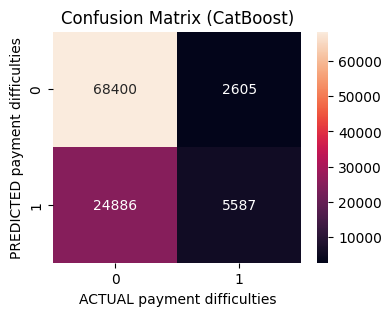

In [58]:
conf_matrix = metrics.confusion_matrix(y_pred, y_test)
plt.figure(figsize=(4, 3))
sns.heatmap(conf_matrix, annot=True, fmt='.0f')
plt.xlabel('ACTUAL payment difficulties')
plt.ylabel('PREDICTED payment difficulties')
plt.title('Confusion Matrix (CatBoost)');

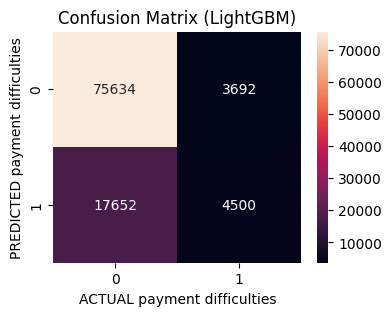

In [59]:
y_pred = lightgbm_model.predict(X_test)
conf_matrix = metrics.confusion_matrix(y_pred, y_test)
plt.figure(figsize=(4, 3))
sns.heatmap(conf_matrix, annot=True, fmt='.0f')
plt.xlabel('ACTUAL payment difficulties')
plt.ylabel('PREDICTED payment difficulties')
plt.title('Confusion Matrix (LightGBM)');

### SHAP

#### CatBoost

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


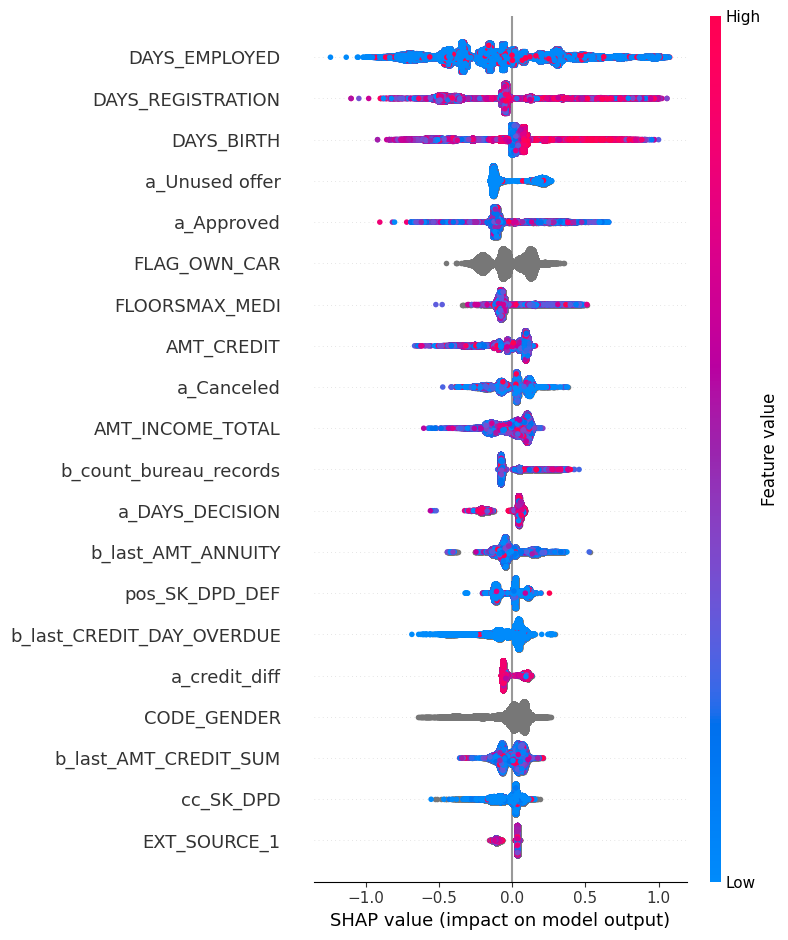

In [64]:
explainer = shap.TreeExplainer(catboost_model)
shap_values = explainer.shap_values(X_train_preprocessed)

shap.summary_plot(shap_values, X_train, plot_type='dot')

#### LightGBM

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


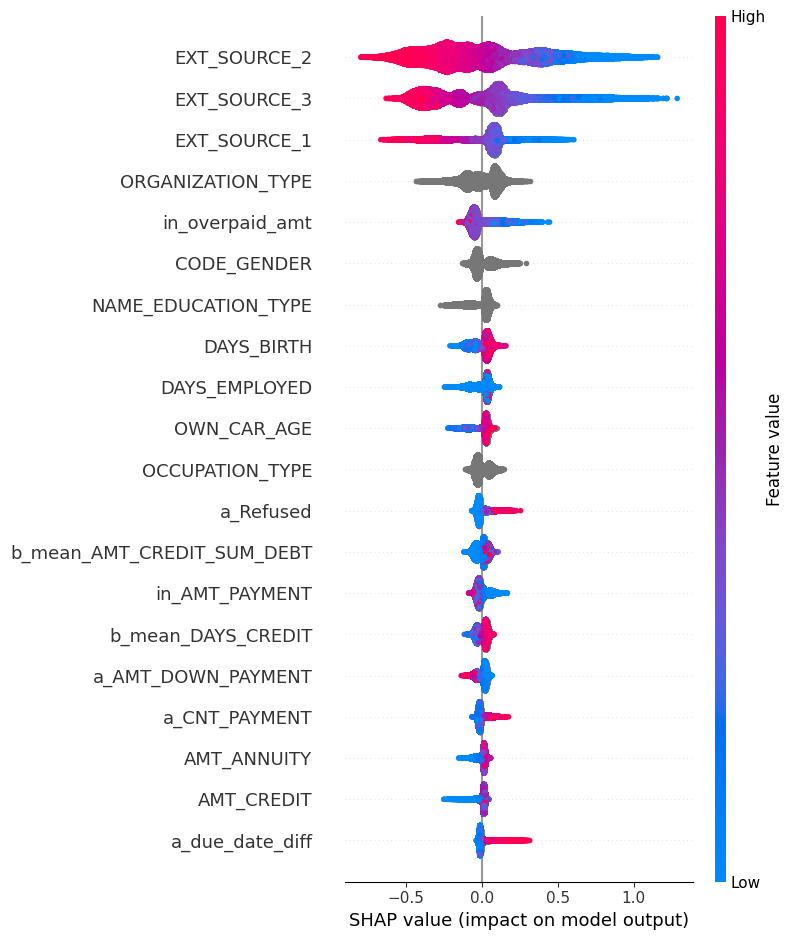

In [78]:
explainer_lightgbm = shap.TreeExplainer(lightgbm_model)
shap_values_lightgbm = explainer_lightgbm.shap_values(X_train)

reshaped_shap_values = shap_values_lightgbm[1].reshape(X_train.shape[0], -1)
shap.summary_plot(reshaped_shap_values, X_train, plot_type='dot')

## Summary
* From EDA 
  * The analysis reveals that younger individuals, those with shorter employment histories, and those with poorer living conditions are more likely to experience payment difficulties. Additionally, low-skill laborers, cleaning and cooking staff, and drivers are more prone to payment difficulties compared to individuals in IT and managerial roles. The approval of loans is influenced by many factors, to name a few: annuity amounts, requested credit amounts, downpayment amounts, Nnmber of payments agreed upon, employment stability.
* From prediction
  * The CatBoost model showed a slightly higher ROC AUC score, while the LightGBM model outperformed in terms of accuracy, F1 weighted score, and F1 macro score. CatBoost AUC ROC score is 0.78, LightGBM 0.76.
  * Both the LightGBM and CatBoost models identify different features as the most important for predicting loan approval. The top 5 features for the LightGBM model are EXT_SOURCE_2, EXT_SOURCE_3, EXT_SOURCE_1, ORGANIZATION_TYPE, and OVERPAID_AMOUNT. On the other hand, the top 5 features for the CatBoost model are DAYS_EMPLOYED, DAYS_REGISTRATION, DAYS_BIRTH, Unused_offer, and FLAG_OWN_CAR. Additional important features for the CatBoost model include FLOORMAX_MEDI, AMT_CREDIT, a_Canceled, and AMT_INCOME_TOTAL.

### What should be improved:
* PCA could be used to reduce the number of features.
* Deeper data pre-processing and including more/different features in modeling.
* Trying more models (Neural Networks, AutoML).